In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No willr CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


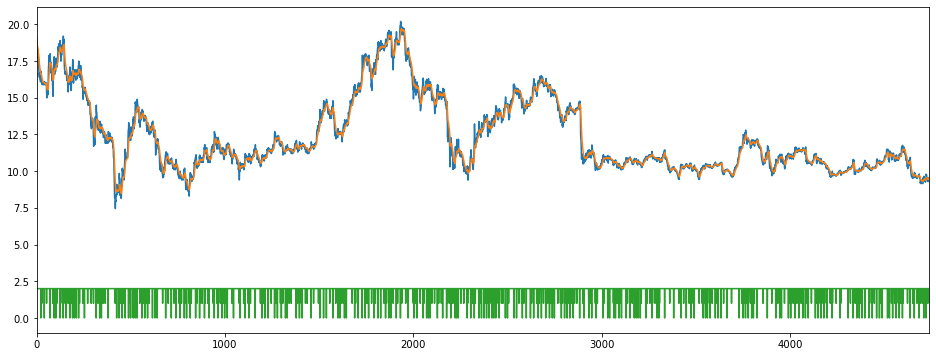

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
#willr_data = np.array(#willr_data)
#willr_data.shape

In [10]:
price_data = np.array(price_data)
price_data.shape

(4725, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4725, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4725, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4725, 64, 64, 1)

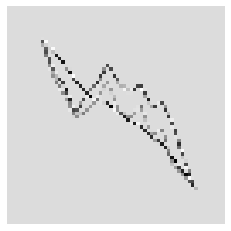

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.6086 - accuracy: 0.6484 - mse: 5.6318 - weighted_accuracy: 0.3063 - weighted_mse: 6.1336WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 49ms/step - loss: 0.2533 - accuracy: 0.3563 - mse: 1.6863 - weighted_accuracy: 0.3623 - weighted_mse: 1.7512 - val_loss: 0.2342 - val_accuracy: 0.0455 - val_mse: 0.9721 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.9721
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 0.2113 - accuracy: 0.1563 - mse: 1.2454 - weighted_accuracy: 0.3285 - weighted_mse: 1.2185 - val_loss: 0.2314 - val_accuracy: 0.0519 - v

Epoch 27/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1962 - accuracy: 0.2696 - mse: 1.1893 - weighted_accuracy: 0.4086 - weighted_mse: 1.1831 - val_loss: 0.2013 - val_accuracy: 0.0720 - val_mse: 1.0240 - val_weighted_accuracy: 0.0720 - val_weighted_mse: 1.0240
Epoch 28/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1955 - accuracy: 0.2704 - mse: 1.1650 - weighted_accuracy: 0.4126 - weighted_mse: 1.1853 - val_loss: 0.2010 - val_accuracy: 0.0868 - val_mse: 0.9509 - val_weighted_accuracy: 0.0868 - val_weighted_mse: 0.9509
Epoch 29/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1945 - accuracy: 0.2854 - mse: 1.2038 - weighted_accuracy: 0.3881 - weighted_mse: 1.2174 - val_loss: 0.1953 - val_accuracy: 0.0656 - val_mse: 1.0657 - val_weighted_accuracy: 0.0656 - val_weighted_mse: 1.0657
Epoch 30/200
30/30 [==============================] - 1s 22ms/step - loss: 0.2004 - accuracy: 0.2198 - mse: 1.1721 - weighted_accuracy: 0.3632 - 

Epoch 56/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1822 - accuracy: 0.2024 - mse: 1.2185 - weighted_accuracy: 0.5298 - weighted_mse: 1.1976 - val_loss: 0.1968 - val_accuracy: 0.0984 - val_mse: 1.0887 - val_weighted_accuracy: 0.0984 - val_weighted_mse: 1.0887
Epoch 57/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1808 - accuracy: 0.1815 - mse: 1.2359 - weighted_accuracy: 0.5279 - weighted_mse: 1.2107 - val_loss: 0.1954 - val_accuracy: 0.1280 - val_mse: 1.0416 - val_weighted_accuracy: 0.1280 - val_weighted_mse: 1.0416
Epoch 58/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1783 - accuracy: 0.1915 - mse: 1.2491 - weighted_accuracy: 0.5352 - weighted_mse: 1.2269 - val_loss: 0.1960 - val_accuracy: 0.0974 - val_mse: 1.1108 - val_weighted_accuracy: 0.0974 - val_weighted_mse: 1.1108
Epoch 59/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1769 - accuracy: 0.1817 - mse: 1.2357 - weighted_accuracy: 0.5502 - 

Epoch 85/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1634 - accuracy: 0.1907 - mse: 1.4005 - weighted_accuracy: 0.5811 - weighted_mse: 1.3634 - val_loss: 0.1937 - val_accuracy: 0.2127 - val_mse: 1.2651 - val_weighted_accuracy: 0.2127 - val_weighted_mse: 1.2651
Epoch 86/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1630 - accuracy: 0.1952 - mse: 1.3922 - weighted_accuracy: 0.5811 - weighted_mse: 1.3724 - val_loss: 0.1961 - val_accuracy: 0.2021 - val_mse: 1.3222 - val_weighted_accuracy: 0.2021 - val_weighted_mse: 1.3222
Epoch 87/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1606 - accuracy: 0.2032 - mse: 1.4314 - weighted_accuracy: 0.5893 - weighted_mse: 1.4038 - val_loss: 0.1976 - val_accuracy: 0.1450 - val_mse: 1.2419 - val_weighted_accuracy: 0.1450 - val_weighted_mse: 1.2419
Epoch 88/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1597 - accuracy: 0.2185 - mse: 1.4272 - weighted_accuracy: 0.6098 - 

Epoch 114/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1450 - accuracy: 0.2577 - mse: 1.6473 - weighted_accuracy: 0.6481 - weighted_mse: 1.6516 - val_loss: 0.1925 - val_accuracy: 0.2603 - val_mse: 1.4947 - val_weighted_accuracy: 0.2603 - val_weighted_mse: 1.4947
Epoch 115/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1461 - accuracy: 0.2672 - mse: 1.6363 - weighted_accuracy: 0.6498 - weighted_mse: 1.6509 - val_loss: 0.1916 - val_accuracy: 0.2720 - val_mse: 1.4920 - val_weighted_accuracy: 0.2720 - val_weighted_mse: 1.4920
Epoch 116/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1408 - accuracy: 0.2870 - mse: 1.6805 - weighted_accuracy: 0.6775 - weighted_mse: 1.7273 - val_loss: 0.1926 - val_accuracy: 0.2571 - val_mse: 1.5232 - val_weighted_accuracy: 0.2571 - val_weighted_mse: 1.5232
Epoch 117/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1471 - accuracy: 0.2812 - mse: 1.6417 - weighted_accuracy: 0.632

Epoch 143/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1348 - accuracy: 0.3601 - mse: 1.8491 - weighted_accuracy: 0.6803 - weighted_mse: 1.9752 - val_loss: 0.1814 - val_accuracy: 0.3471 - val_mse: 1.5759 - val_weighted_accuracy: 0.3471 - val_weighted_mse: 1.5759
Epoch 144/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1343 - accuracy: 0.3458 - mse: 1.8606 - weighted_accuracy: 0.6935 - weighted_mse: 2.0087 - val_loss: 0.1819 - val_accuracy: 0.3788 - val_mse: 1.6740 - val_weighted_accuracy: 0.3788 - val_weighted_mse: 1.6740
Epoch 145/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1292 - accuracy: 0.3574 - mse: 1.8886 - weighted_accuracy: 0.7237 - weighted_mse: 2.0758 - val_loss: 0.1800 - val_accuracy: 0.3873 - val_mse: 1.6191 - val_weighted_accuracy: 0.3873 - val_weighted_mse: 1.6191
Epoch 146/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1310 - accuracy: 0.3714 - mse: 1.9118 - weighted_accuracy: 0.693

Epoch 172/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1196 - accuracy: 0.4701 - mse: 2.1580 - weighted_accuracy: 0.7446 - weighted_mse: 2.6203 - val_loss: 0.1697 - val_accuracy: 0.5026 - val_mse: 1.8638 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 1.8638
Epoch 173/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1270 - accuracy: 0.4553 - mse: 2.0810 - weighted_accuracy: 0.7169 - weighted_mse: 2.4795 - val_loss: 0.1731 - val_accuracy: 0.4836 - val_mse: 1.8944 - val_weighted_accuracy: 0.4836 - val_weighted_mse: 1.8944
Epoch 174/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1210 - accuracy: 0.4537 - mse: 2.1358 - weighted_accuracy: 0.7330 - weighted_mse: 2.5747 - val_loss: 0.1754 - val_accuracy: 0.4519 - val_mse: 1.8905 - val_weighted_accuracy: 0.4519 - val_weighted_mse: 1.8905
Epoch 175/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1209 - accuracy: 0.4627 - mse: 2.1163 - weighted_accuracy: 0.730

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15442001819610596
Test accuracy: 0.6190476417541504


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.268296   -2.9568236  -0.84665585]
 [-1.3245486  -1.0288627  -0.42505497]
 [-2.06874    -0.5844475  -0.6266562 ]
 ...
 [-2.0574164  -0.648998   -0.35841864]
 [-1.3197901  -0.9409894  -0.32008833]
 [-1.149449   -1.387843   -0.36289835]]


Counter({0: 174, 2: 596, 1: 175})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 945
actual predicted buys: 22
actual buys but predicted sell: 2
actual buys but predicted hold: 19
actual sells but predicted buy: 1
actual predicted sells: 14
actual sells but predicted hold: 28
actual holds but predicted buy: 152
actual holds but predicted sell: 158
actual predicted holds: 549
Percentage buys correct: 51.16279069767442%
Percentage sells correct: 32.55813953488372%
Percentage holds correct: 63.91152502910361%
actual buys: 43
actual sells: 43
actual holds: 859


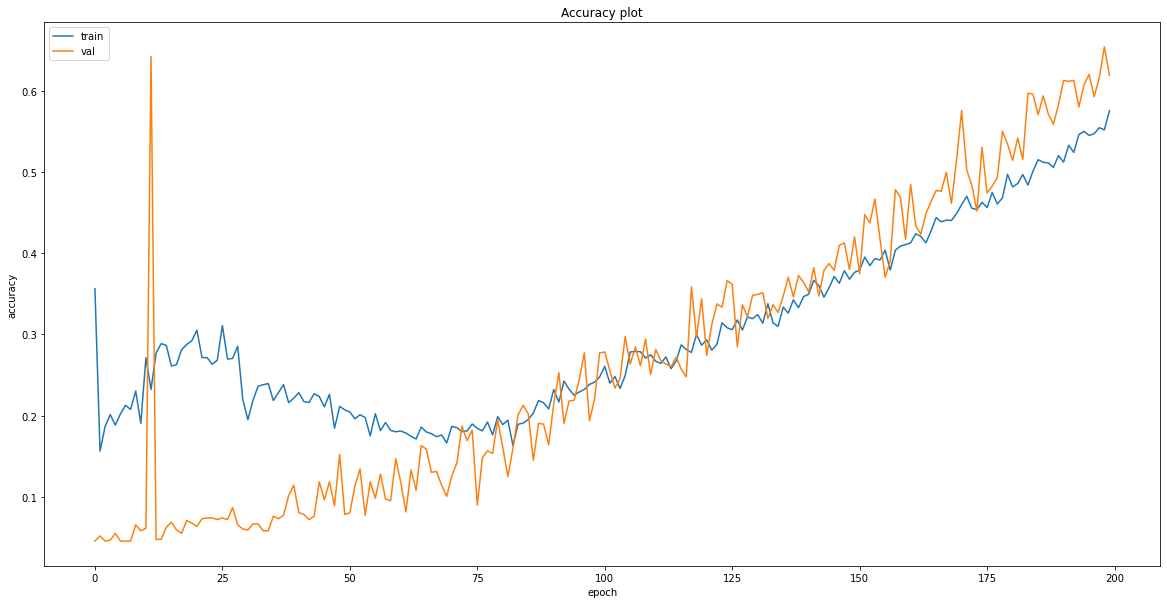

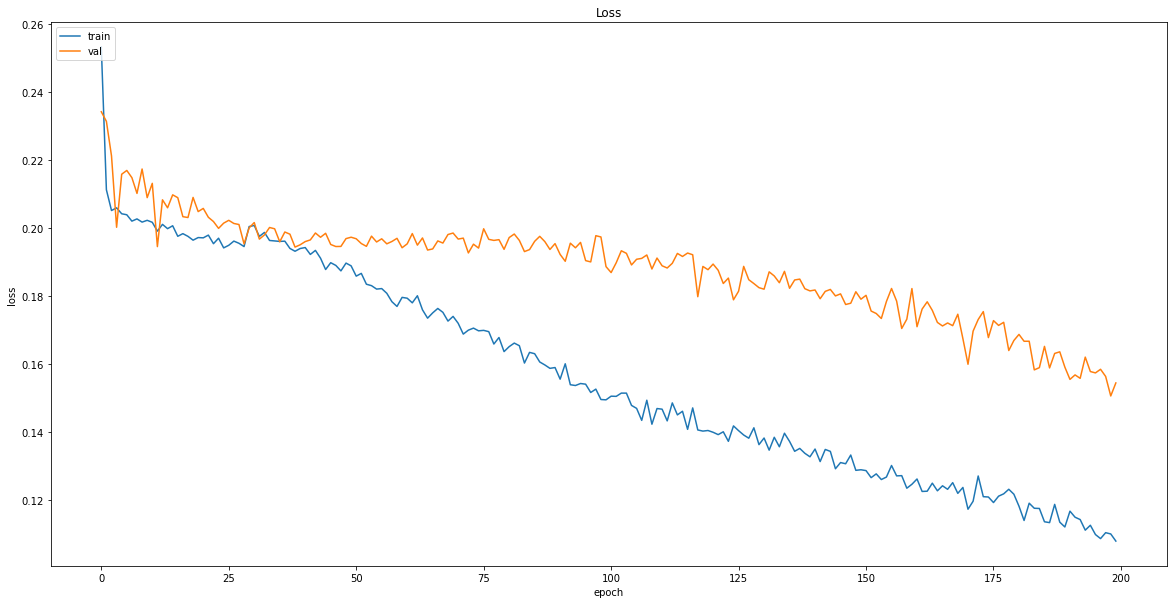

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_no_willr.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


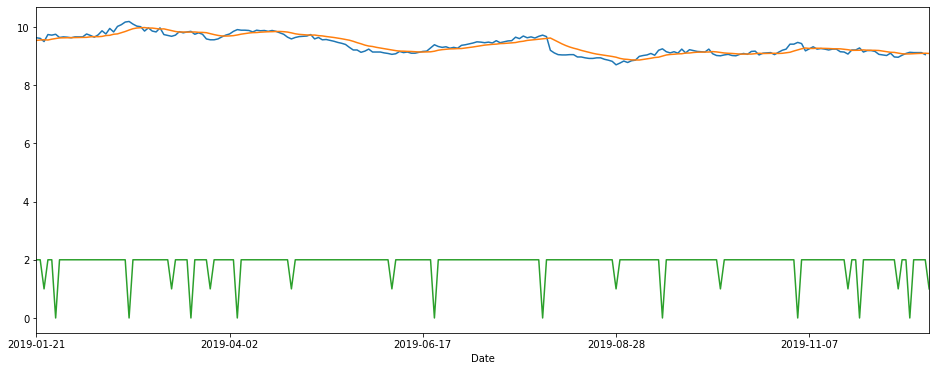

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [32]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [34]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1612 - accuracy: 0.6376 - mean_squared_error: 2.0992 - weighted_accuracy: 0.6376 - weighted_mean_squared_error: 2.0992
Test loss: 0.1612366884946823
Test accuracy: 0.6376146674156189


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 138, 0: 44, 1: 36})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [39]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [40]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            0   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

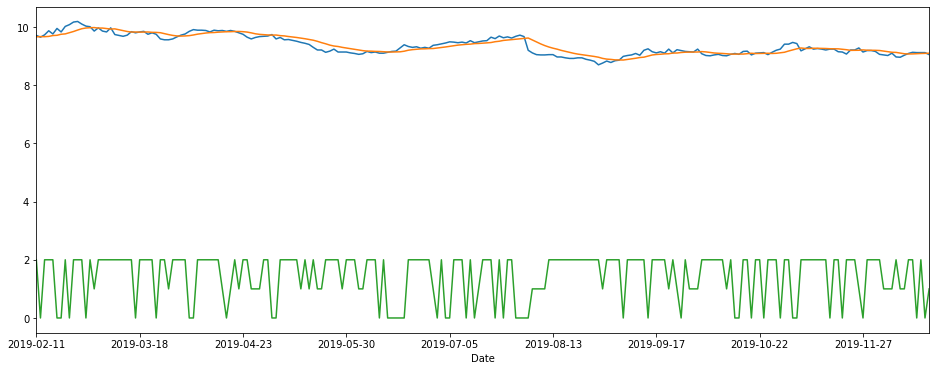

In [41]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

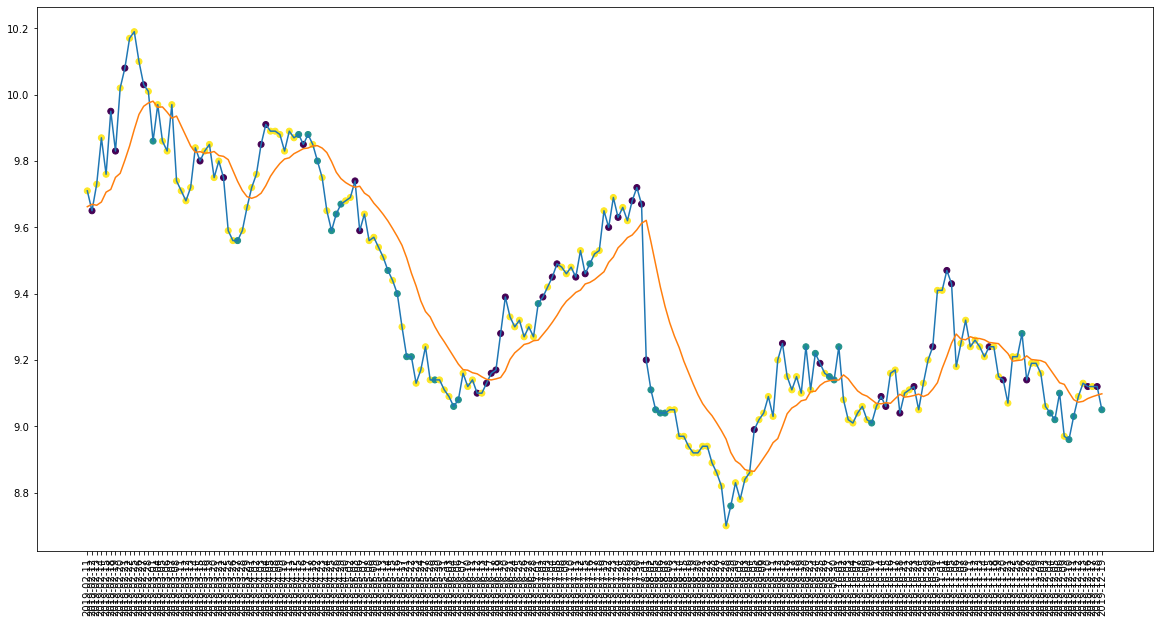

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

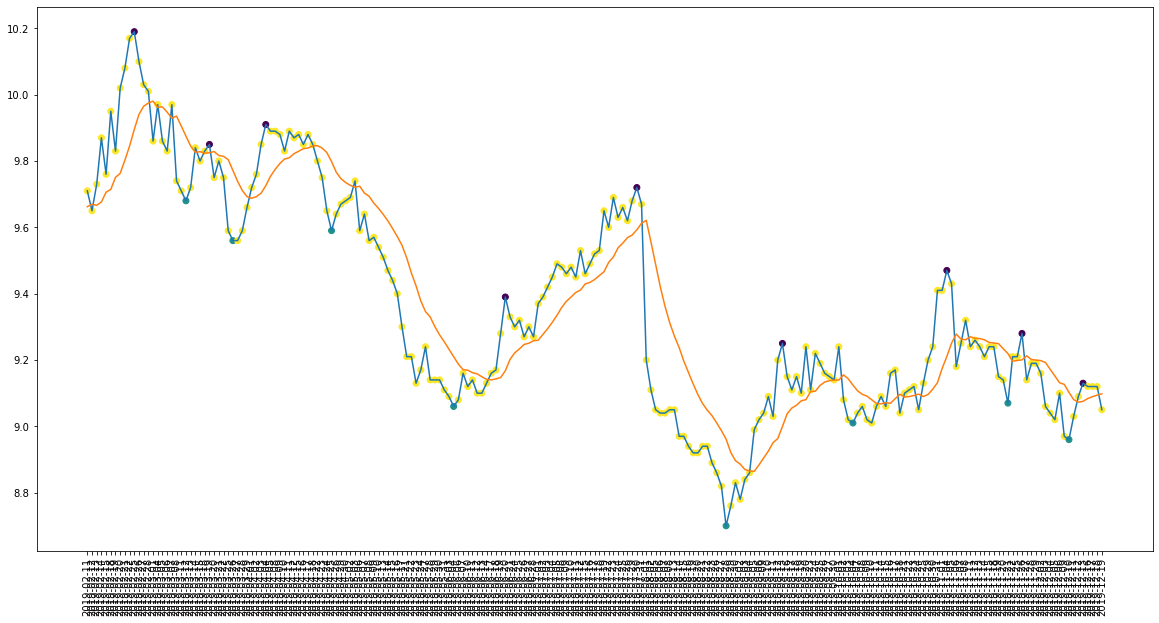

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [44]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 31
actual holds but predicted sell: 39
actual predicted holds: 130
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 65.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [45]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 43.18181818181818%
Percentage holds correct: 81.8840579710145%


In [46]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.859999656677246
Shares owned at the moment: 1011
Cash capital at the moment: $4.1270830538269365


Stop Loss Activated!

Share price: $9.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9672.954639395952


Share price: $9.5600004196167
Shares owned at the moment: 1009
Cash capital at the moment: $0.38760483836995263


Stop Loss Activated!

Share price: $9.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9267.722195722818


Share price: $9.210000038146973
Shares owned at the moment: 1003
Cash capital at the moment: $4.688674856184662


Price increase from previously bought: 5.2480296640206925%
Share price: $9.720000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9727.038751949545


Share price: $9.109999656677246
Shares owned at the moment: 1064
Cash capital at the moment: $7.343258249517021


Stop Loss Activated!

Share price: $8.859999656677246
Shares owned at the moment: 0
Cash capital at the mome

In [47]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


In [48]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells correct_holds  \
0       0.637615  44.44444444444444%  55.55555555555556%         65.0%   

      correct_low_buys  correct_high_sells  correct_mid_holds  \
0  57.142857142857146%  43.18181818181818%  81.8840579710145%   

         Profit gained   buy_n_hold profit  
0  -4.180562670910404%  -7.30802773938658%

### Recession

In [49]:
logger = []

In [50]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


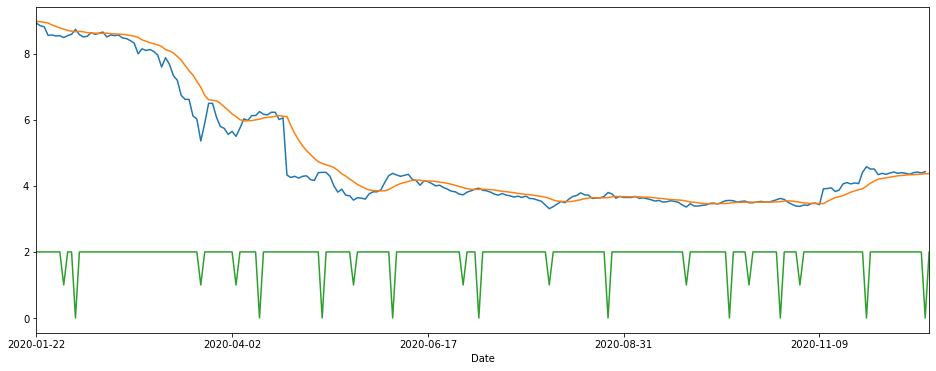

In [51]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [52]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1586 - accuracy: 0.6233 - mean_squared_error: 2.1202 - weighted_accuracy: 0.6233 - weighted_mean_squared_error: 2.1202
Test loss: 0.15855617821216583
Test accuracy: 0.6232557892799377


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 135, 0: 25, 1: 55})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [60]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [61]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            0   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            0   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            2   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

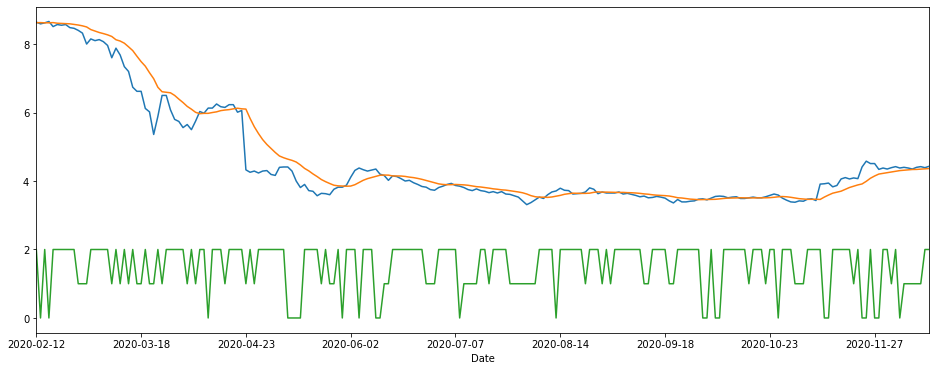

In [62]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

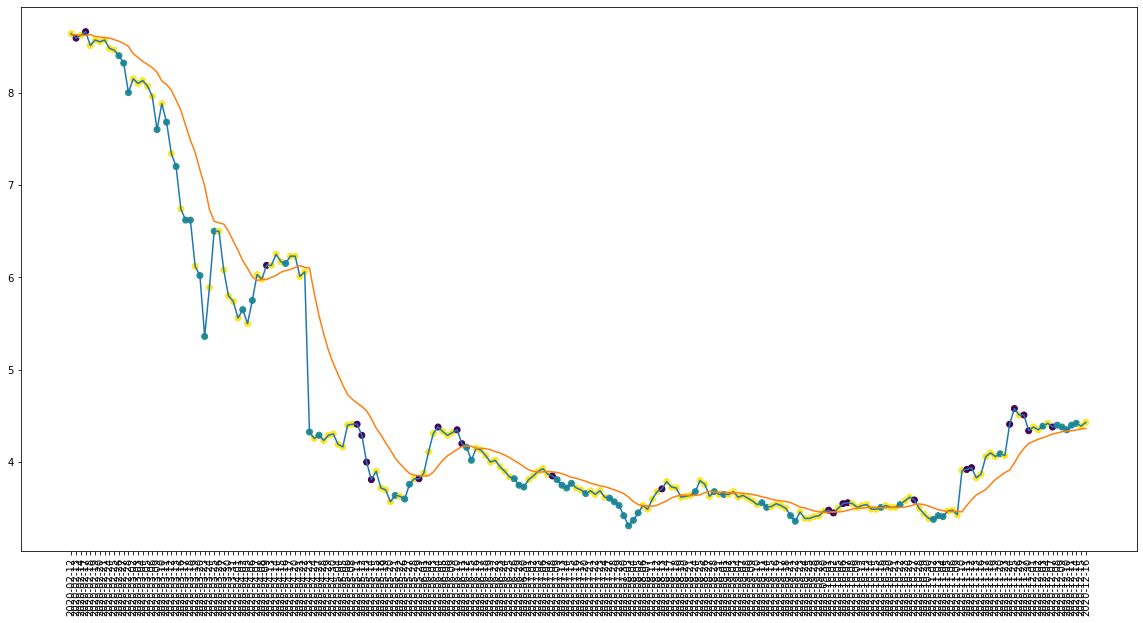

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

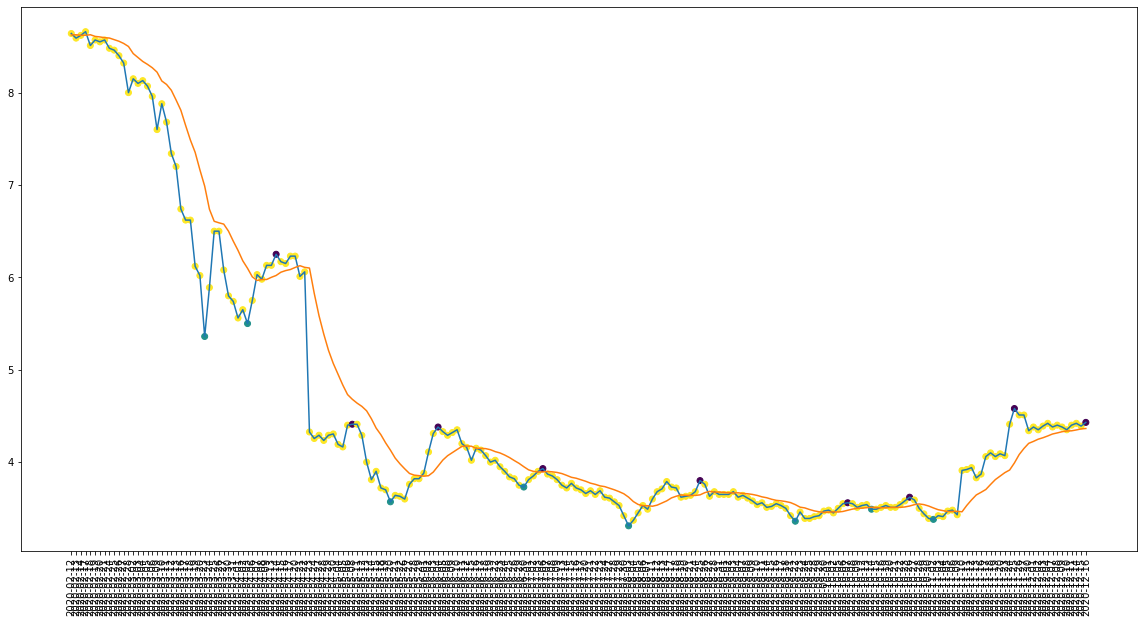

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [65]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 50
actual holds but predicted sell: 22
actual predicted holds: 126
Percentage buys correct: 62.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 63.63636363636363%
actual buys: 8
actual sells: 9
actual holds: 198


In [66]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 72.0%
Percentage holds correct: 87.31343283582089%


In [67]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.399999618530272
Shares owned at the moment: 1187
Cash capital at the moment: $1.7807540497797163


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9471.66675404978


Share price: $8.0
Shares owned at the moment: 1180
Cash capital at the moment: $5.706754049779192


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $8949.044641825674


Share price: $7.599999904632567
Shares owned at the moment: 1174
Cash capital at the moment: $2.1081540949344344


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8595.57114274049


Share price: $7.199999809265138
Shares owned at the moment: 1190
Cash capital at the moment: $4.009370339153975


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8002.552448718785


Share price: $6.619999885559082
Shares 

In [68]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


In [69]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.637615  44.44444444444444%   55.55555555555556%               65.0%   
1       0.623256               62.5%  33.333333333333336%  63.63636363636363%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0  57.142857142857146%  43.18181818181818%   81.8840579710145%   
1   54.54545454545455%               72.0%  87.31343283582089%   

          Profit gained     buy_n_hold profit  
0   -4.180562670910404%    -7.30802773938658%  
1  -40.609763038500056%  -48.998182398364555%

### OCBC Bank

In [70]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


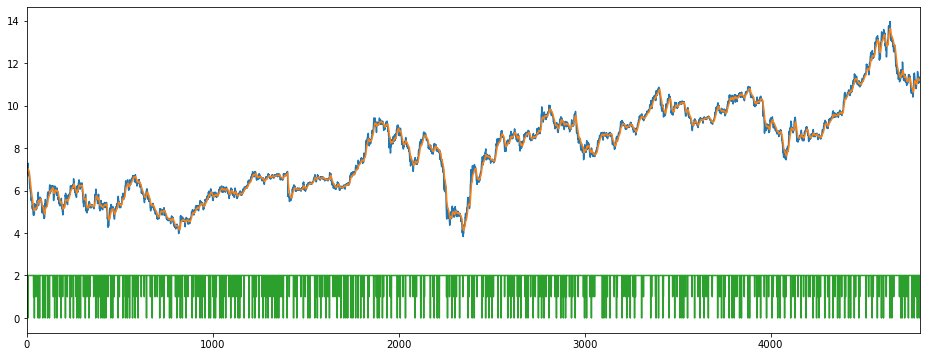

In [71]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [72]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [73]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [74]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [76]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4789, 64, 64, 1)

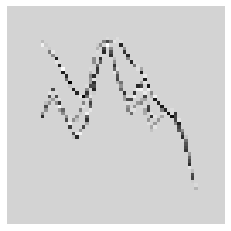

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}
Epoch 1/200
30/30 [==============================] - 11s 369ms/step - loss: 0.2434 - accuracy: 0.3516 - mse: 1.6733 - weighted_accuracy: 0.3382 - weighted_mse: 1.6656 - val_loss: 0.2004 - val_accuracy: 0.0511 - val_mse: 1.0895 - val_weighted_accuracy: 0.0511 - val_weighted_mse: 1.0895
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 0.2048 - accuracy: 0.4022 - mse: 1.1771 - weighted_accuracy: 0.3382 - weighted_mse: 1.1935 - val_loss: 0.2008 - val_accuracy: 0.0960 - val_mse: 0.9339 - val_weighted_accuracy: 0.0960 - val_weighted_mse: 0.9339
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 0.2047 - accuracy: 0.4038 - mse: 1.1614 - weighted_accuracy: 0.3439 - weighted_mse: 1.1675 - val_loss: 0.1981 - val_accuracy: 0.0793 - val_mse: 0.9667 - val_weighted_accuracy: 0.0793 - val_weighted_mse: 0.9667
Epoch 4/200
30/30 [==============================] - 1s 19ms/step - loss: 0.20

30/30 [==============================] - 1s 35ms/step - loss: 0.1968 - accuracy: 0.3769 - mse: 1.1662 - weighted_accuracy: 0.4048 - weighted_mse: 1.1645 - val_loss: 0.1884 - val_accuracy: 0.5000 - val_mse: 0.9513 - val_weighted_accuracy: 0.5000 - val_weighted_mse: 0.9513
Epoch 29/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1954 - accuracy: 0.3459 - mse: 1.1952 - weighted_accuracy: 0.3798 - weighted_mse: 1.1967 - val_loss: 0.2014 - val_accuracy: 0.0908 - val_mse: 0.8830 - val_weighted_accuracy: 0.0908 - val_weighted_mse: 0.8830
Epoch 30/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1964 - accuracy: 0.3383 - mse: 1.1673 - weighted_accuracy: 0.3782 - weighted_mse: 1.1582 - val_loss: 0.1911 - val_accuracy: 0.1879 - val_mse: 1.0140 - val_weighted_accuracy: 0.1879 - val_weighted_mse: 1.0140
Epoch 31/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1944 - accuracy: 0.3474 - mse: 1.1854 - weighted_accuracy: 0.3978 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1806 - accuracy: 0.2206 - mse: 1.2949 - weighted_accuracy: 0.4982 - weighted_mse: 1.2542 - val_loss: 0.1946 - val_accuracy: 0.1294 - val_mse: 1.0754 - val_weighted_accuracy: 0.1294 - val_weighted_mse: 1.0754
Epoch 58/200
30/30 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.2702 - mse: 1.3162 - weighted_accuracy: 0.4572 - weighted_mse: 1.287 - 1s 34ms/step - loss: 0.1819 - accuracy: 0.2702 - mse: 1.3162 - weighted_accuracy: 0.4572 - weighted_mse: 1.2875 - val_loss: 0.1943 - val_accuracy: 0.0877 - val_mse: 1.1309 - val_weighted_accuracy: 0.0877 - val_weighted_mse: 1.1309
Epoch 59/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1759 - accuracy: 0.2195 - mse: 1.3085 - weighted_accuracy: 0.4926 - weighted_mse: 1.2733 - val_loss: 0.1899 - val_accuracy: 0.1994 - val_mse: 1.0943 - val_weighted_accuracy: 0.1994 - val_weighted_mse: 1.0943
Epoch 60/200
30/30 [=================

Epoch 85/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1604 - accuracy: 0.1809 - mse: 1.4339 - weighted_accuracy: 0.5784 - weighted_mse: 1.3862 - val_loss: 0.1945 - val_accuracy: 0.1587 - val_mse: 1.2425 - val_weighted_accuracy: 0.1587 - val_weighted_mse: 1.2425
Epoch 86/200
30/30 [==============================] - 1s 29ms/step - loss: 0.1612 - accuracy: 0.1689 - mse: 1.4447 - weighted_accuracy: 0.5599 - weighted_mse: 1.3966 - val_loss: 0.1916 - val_accuracy: 0.1931 - val_mse: 1.2830 - val_weighted_accuracy: 0.1931 - val_weighted_mse: 1.2830
Epoch 87/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1646 - accuracy: 0.1848 - mse: 1.4814 - weighted_accuracy: 0.5479 - weighted_mse: 1.4263 - val_loss: 0.2016 - val_accuracy: 0.1441 - val_mse: 1.4381 - val_weighted_accuracy: 0.1441 - val_weighted_mse: 1.4381
Epoch 88/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1595 - accuracy: 0.1608 - mse: 1.5770 - weighted_accuracy: 0.5911 - 

Epoch 114/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1364 - accuracy: 0.3119 - mse: 1.8751 - weighted_accuracy: 0.6851 - weighted_mse: 1.9067 - val_loss: 0.1888 - val_accuracy: 0.3278 - val_mse: 1.6264 - val_weighted_accuracy: 0.3278 - val_weighted_mse: 1.6264
Epoch 115/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1397 - accuracy: 0.3080 - mse: 1.7686 - weighted_accuracy: 0.6694 - weighted_mse: 1.7926 - val_loss: 0.1917 - val_accuracy: 0.3278 - val_mse: 1.6173 - val_weighted_accuracy: 0.3278 - val_weighted_mse: 1.6173
Epoch 116/200
30/30 [==============================] - 1s 30ms/step - loss: 0.1416 - accuracy: 0.2937 - mse: 1.7790 - weighted_accuracy: 0.6651 - weighted_mse: 1.7841 - val_loss: 0.1840 - val_accuracy: 0.3403 - val_mse: 1.5699 - val_weighted_accuracy: 0.3403 - val_weighted_mse: 1.5699
Epoch 117/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1390 - accuracy: 0.3054 - mse: 1.8183 - weighted_accuracy: 0.670

Epoch 143/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1250 - accuracy: 0.4427 - mse: 2.0432 - weighted_accuracy: 0.7298 - weighted_mse: 2.1727 - val_loss: 0.1795 - val_accuracy: 0.4384 - val_mse: 1.7871 - val_weighted_accuracy: 0.4384 - val_weighted_mse: 1.7871
Epoch 144/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1286 - accuracy: 0.4417 - mse: 2.0360 - weighted_accuracy: 0.7271 - weighted_mse: 2.1484 - val_loss: 0.1803 - val_accuracy: 0.4175 - val_mse: 1.7638 - val_weighted_accuracy: 0.4175 - val_weighted_mse: 1.7638
Epoch 145/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1294 - accuracy: 0.4362 - mse: 2.0001 - weighted_accuracy: 0.7028 - weighted_mse: 2.1427 - val_loss: 0.1695 - val_accuracy: 0.5031 - val_mse: 1.6984 - val_weighted_accuracy: 0.5031 - val_weighted_mse: 1.6984
Epoch 146/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1249 - accuracy: 0.4414 - mse: 2.0569 - weighted_accuracy: 0.710

Epoch 172/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1159 - accuracy: 0.5636 - mse: 2.3821 - weighted_accuracy: 0.7375 - weighted_mse: 2.7657 - val_loss: 0.1590 - val_accuracy: 0.5720 - val_mse: 1.9709 - val_weighted_accuracy: 0.5720 - val_weighted_mse: 1.9709
Epoch 173/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1125 - accuracy: 0.5636 - mse: 2.4591 - weighted_accuracy: 0.7580 - weighted_mse: 2.8771 - val_loss: 0.1466 - val_accuracy: 0.6534 - val_mse: 1.8938 - val_weighted_accuracy: 0.6534 - val_weighted_mse: 1.8938
Epoch 174/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1151 - accuracy: 0.5482 - mse: 2.3545 - weighted_accuracy: 0.7340 - weighted_mse: 2.7630 - val_loss: 0.1503 - val_accuracy: 0.6180 - val_mse: 1.9432 - val_weighted_accuracy: 0.6180 - val_weighted_mse: 1.9432
Epoch 175/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1125 - accuracy: 0.5521 - mse: 2.4694 - weighted_accuracy: 0.741

In [84]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13839100301265717
Test accuracy: 0.6941545009613037


In [85]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.58201313 -2.4023435  -1.107278  ]
 [-2.179754   -0.04819822 -0.6407312 ]
 [-0.94927704 -1.6717321   0.00677924]
 ...
 [-1.1428479  -1.0334696  -0.08510718]
 [ 0.07822619 -2.9604008  -0.7925846 ]
 [-2.1495175  -0.73943305 -0.2571279 ]]


Counter({0: 169, 1: 80, 2: 709})

In [86]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [87]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 31
actual sells but predicted buy: 0
actual predicted sells: 12
actual sells but predicted hold: 32
actual holds but predicted buy: 73
actual holds but predicted sell: 155
actual predicted holds: 646
Percentage buys correct: 17.5%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 73.91304347826087%
actual buys: 40
actual sells: 44
actual holds: 874


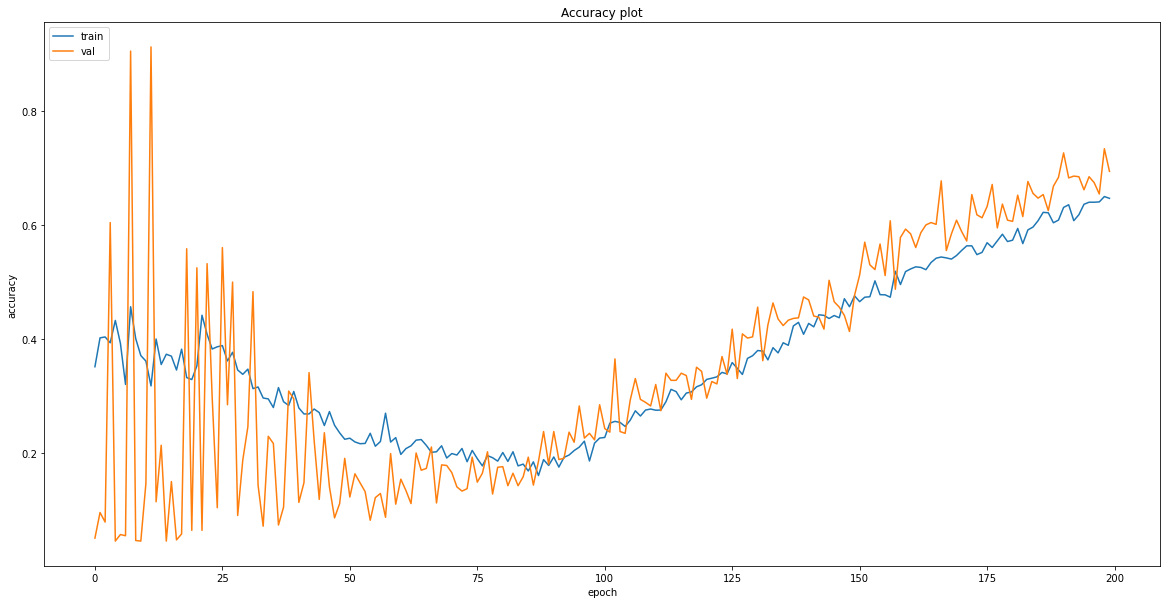

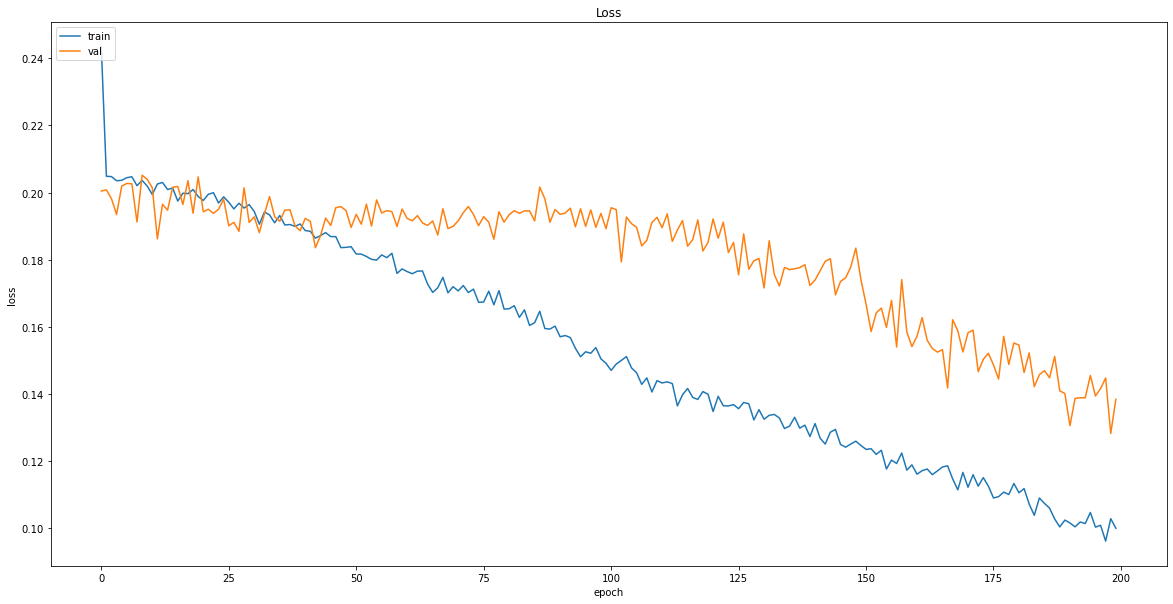

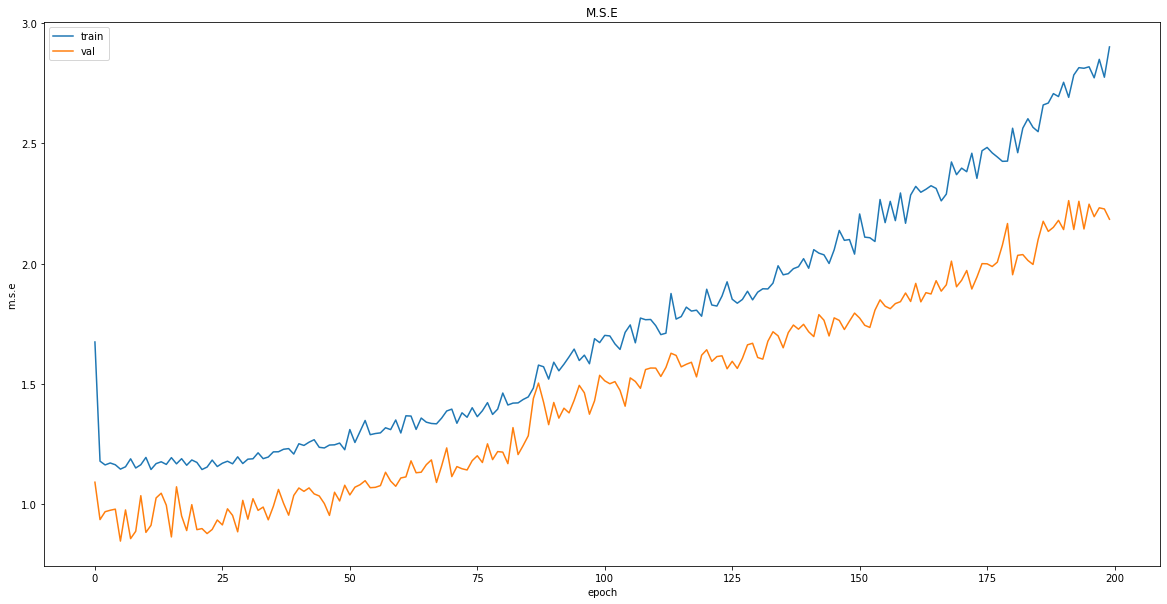

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

#### Non-Recession

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


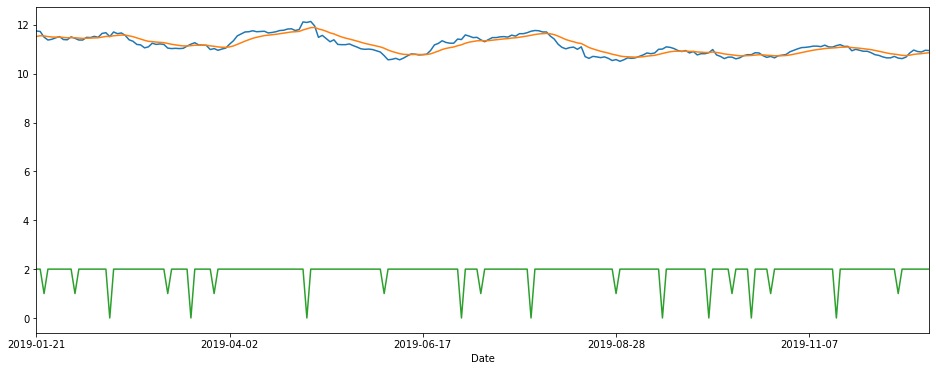

In [92]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

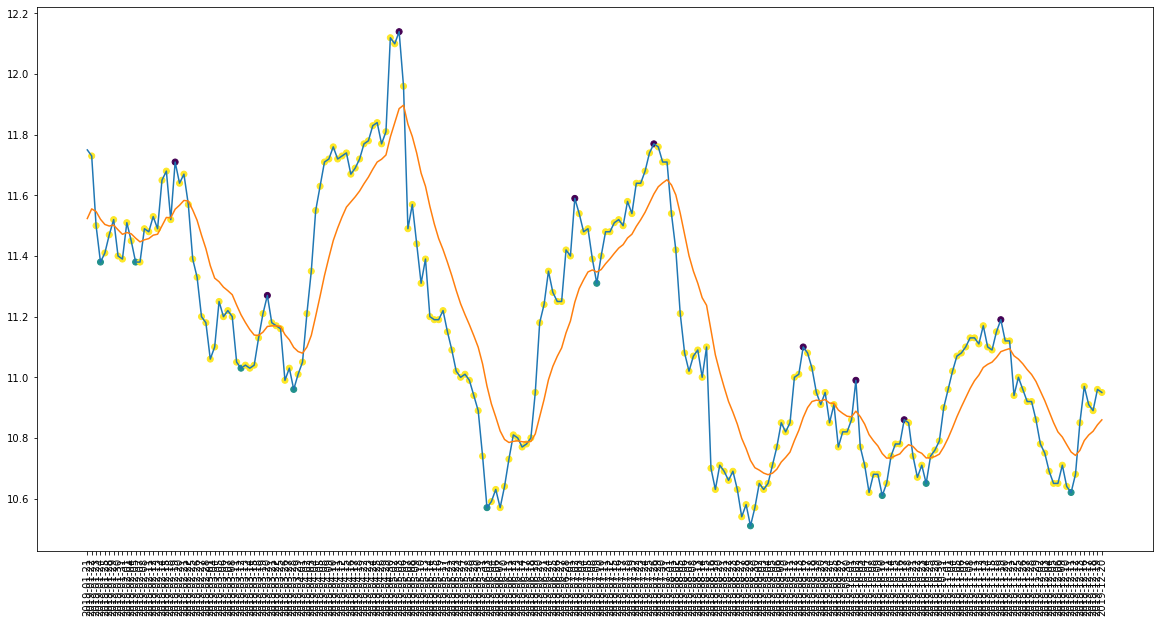

In [93]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [94]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [96]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [97]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [98]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.6743 - mean_squared_error: 2.2893 - weighted_accuracy: 0.6743 - weighted_mean_squared_error: 2.2893
Test loss: 0.14058361947536469
Test accuracy: 0.6743119359016418


In [99]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 148, 0: 49, 1: 21})

In [100]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [101]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [102]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            0       2  
2019-02-14            0       2  
2019-02-15            2       2

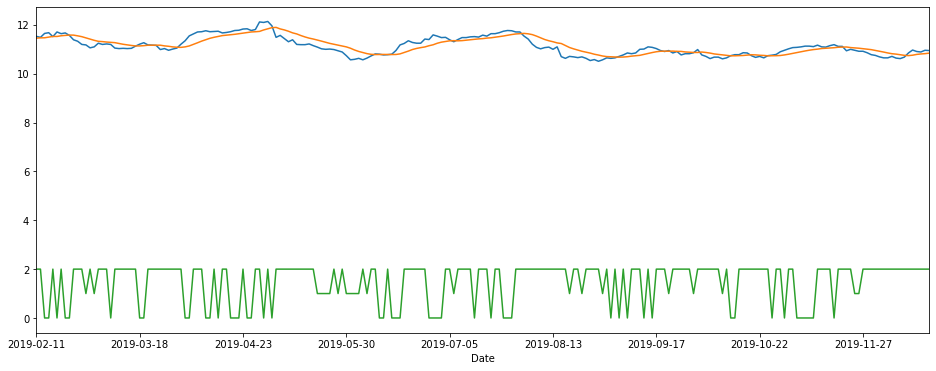

In [104]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

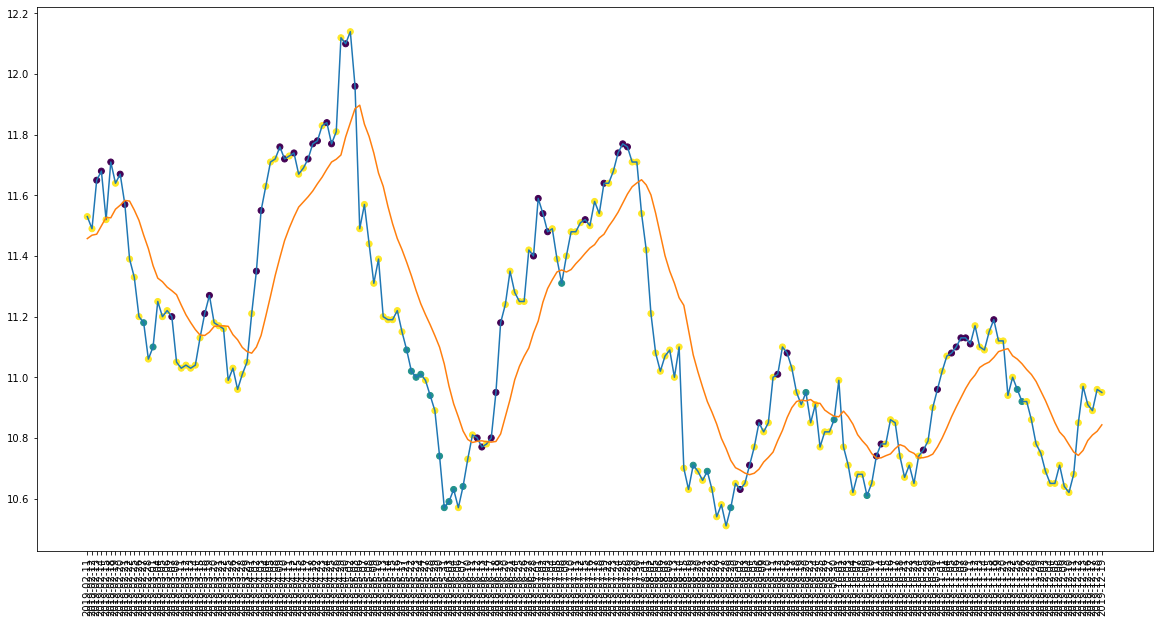

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

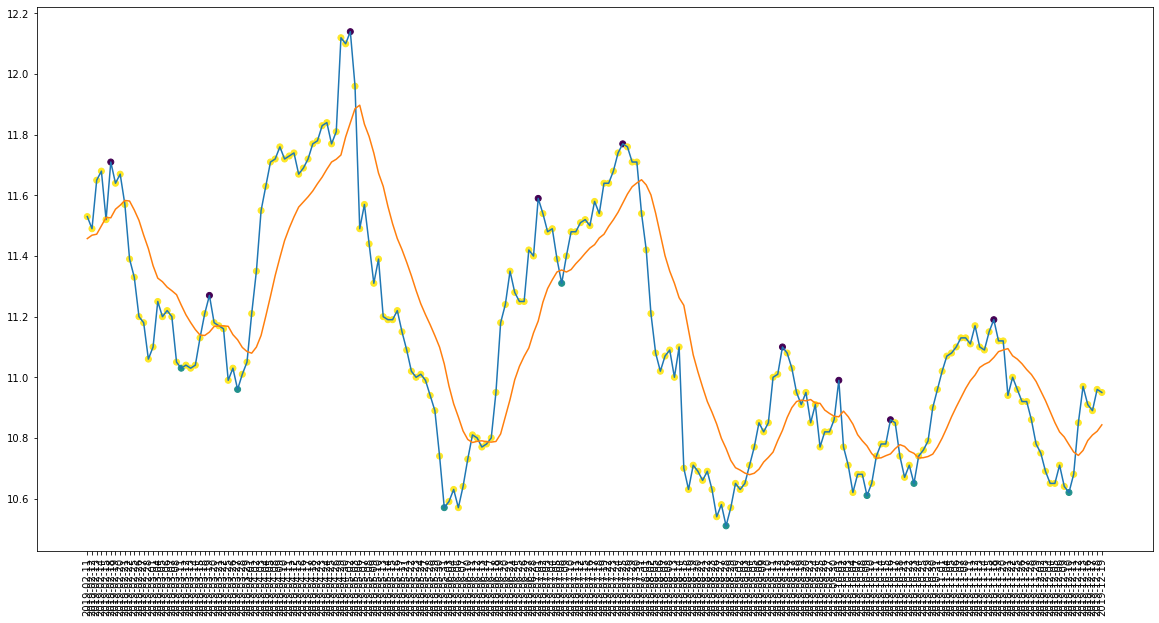

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [107]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 18
actual holds but predicted sell: 44
actual predicted holds: 139
Percentage buys correct: 37.5%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 69.1542288557214%
actual buys: 8
actual sells: 9
actual holds: 201


In [108]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 47.61904761904762%
Percentage sells correct: 65.3061224489796%
Percentage holds correct: 86.39455782312925%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Price increase from previously bought: 5.077757200056565%
Share price: $11.779999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10478.878609499934


Share price: $11.09000015258789
Shares owned at the moment: 942
Cash capital at the moment: $3.3698203668627684


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10092.627635353092


Share price: $10.739999771118164
Shares owned at the moment: 937
Cash capital at the moment: $1.5735554051425424


Price increase from previously bought: 5.854151191091073%
Share price: $11.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10653.99824895096


Share price: $11.3100004196167
Shares owned at the moment: 939
Cash capital at the moment: $4.702606347324036


Stop Loss Activated!

Share price: $11.0
Shares owned at the moment

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.637615  44.44444444444444%   55.55555555555556%               65.0%   
1       0.623256               62.5%  33.333333333333336%  63.63636363636363%   
2       0.674312               37.5%   55.55555555555556%   69.1542288557214%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0  57.142857142857146%  43.18181818181818%   81.8840579710145%   
1   54.54545454545455%               72.0%  87.31343283582089%   
2   47.61904761904762%   65.3061224489796%  86.39455782312925%   

          Profit gained     buy_n_hold profit  
0   -4.180562670910404%    -7.30802773938658%  
1  -40.609763038500056%  -48.998182398364555%  
2    4.783348022520549%   -5.545324129943856%

#### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


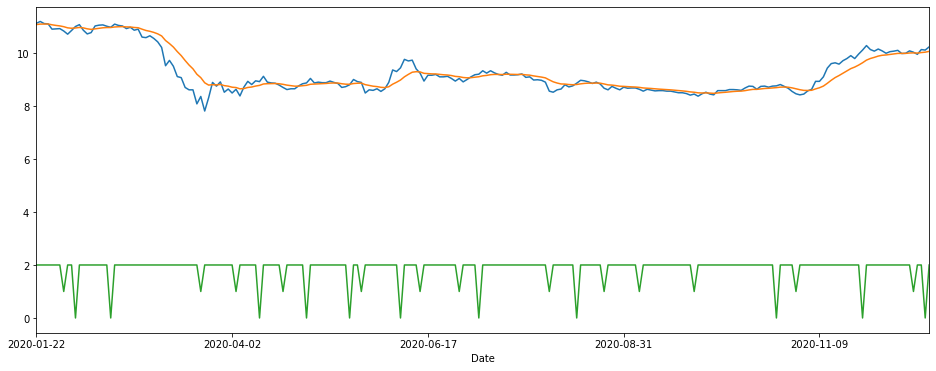

In [114]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

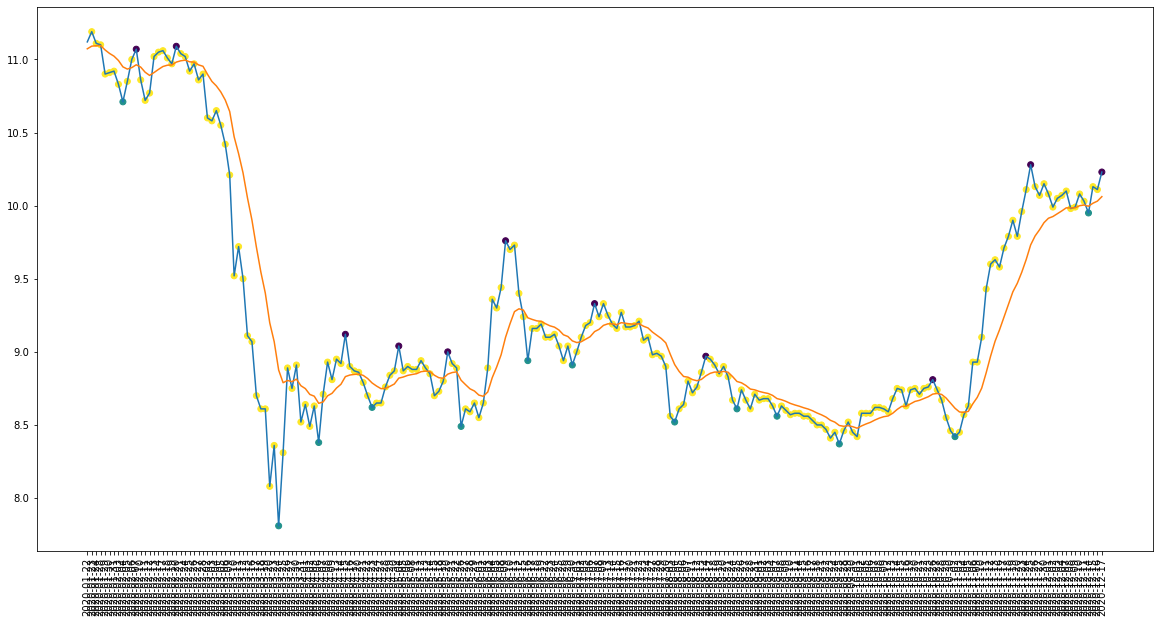

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.7535 - mean_squared_error: 2.2506 - weighted_accuracy: 0.7535 - weighted_mean_squared_error: 2.2506
Test loss: 0.13218742609024048
Test accuracy: 0.7534883618354797


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 165, 0: 34, 1: 16})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [123]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            2       2

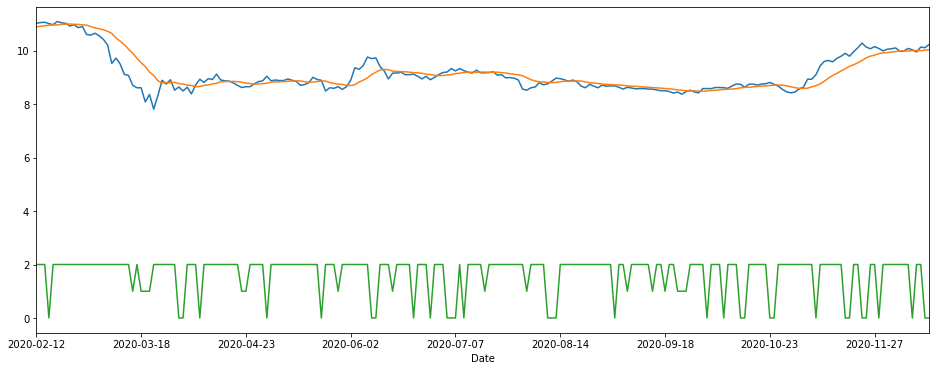

In [125]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

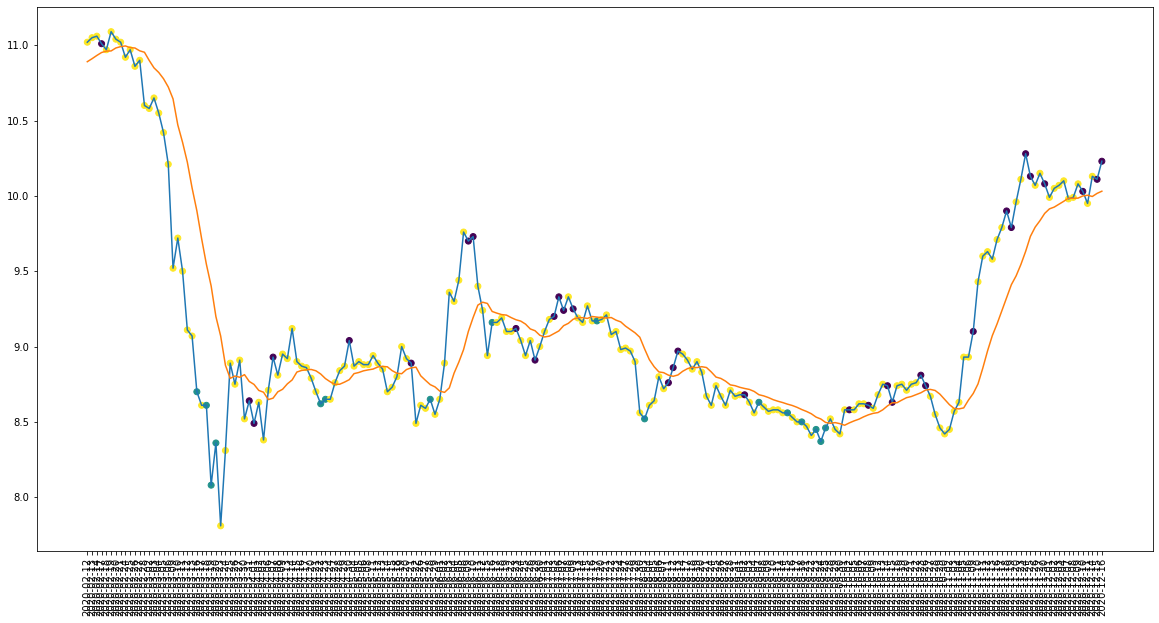

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

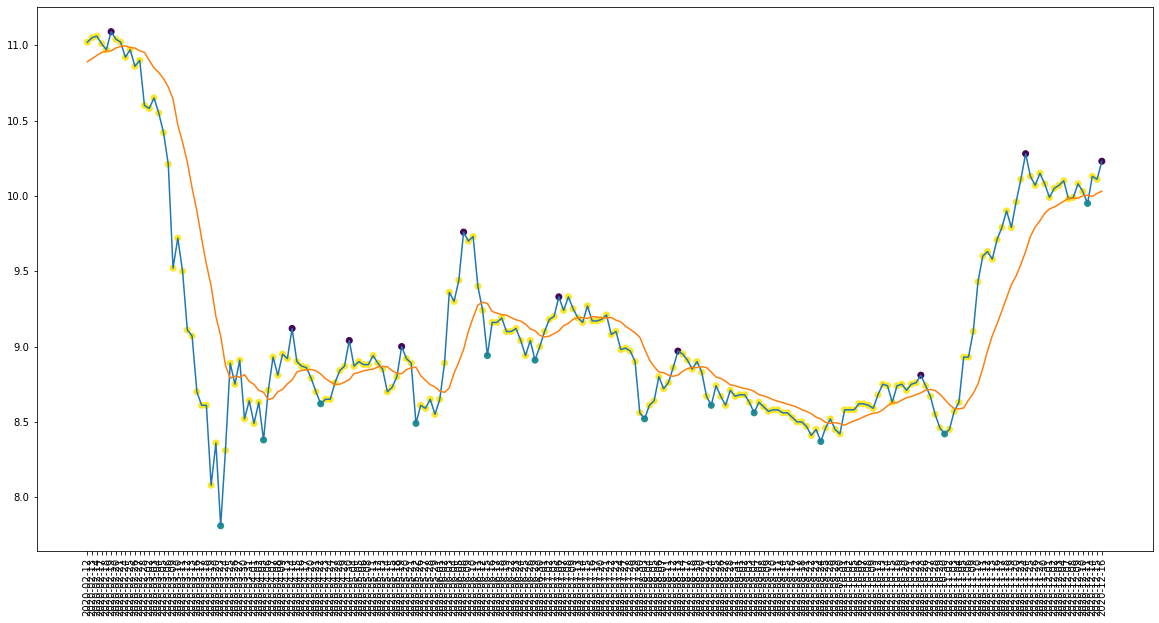

In [127]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [128]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 13
actual holds but predicted sell: 27
actual predicted holds: 153
Percentage buys correct: 25.0%
Percentage sells correct: 60.0%
Percentage holds correct: 79.27461139896373%
actual buys: 12
actual sells: 10
actual holds: 193


In [129]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 56.25%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 87.87878787878788%


In [130]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.699999809265138
Shares owned at the moment: 1146
Cash capital at the moment: $2.3821691832526994


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9236.597961990832


Share price: $8.079999923706055
Shares owned at the moment: 1140
Cash capital at the moment: $0.0672492051107838


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8878.982834153174


Share price: $8.619999885559082
Shares owned at the moment: 1027
Cash capital at the moment: $1.8979170072052511


Price increase from previously bought: 12.220395513779781%
Share price: $9.699999809265137
Shares owned at the moment: 0
Cash capital at the moment: $9936.402496661183


Share price: $9.15999984741211
Shares owned at the moment: 1081
Cash capital at the moment: $7.212272062299235


Stop Loss Activated!

Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the mo

In [131]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [132]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.637615  44.44444444444444%   55.55555555555556%               65.0%   
1       0.623256               62.5%  33.333333333333336%  63.63636363636363%   
2       0.674312               37.5%   55.55555555555556%   69.1542288557214%   
3       0.753488               25.0%                60.0%  79.27461139896373%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0  57.142857142857146%  43.18181818181818%   81.8840579710145%   
1   54.54545454545455%               72.0%  87.31343283582089%   
2   47.61904761904762%   65.3061224489796%  86.39455782312925%   
3               56.25%  66.66666666666667%  87.87878787878788%   

          Profit gained     buy_n_hold profit  
0   -4.180562670910404%    -7.30802773938658%  
1  -40.609763038500056%  -48.998182398364555%  
2    4.783348022520549%   -5.545324129943856%  
3    1.985793325576724%   -7.669883276367181%

## CNOOC Limited

In [133]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


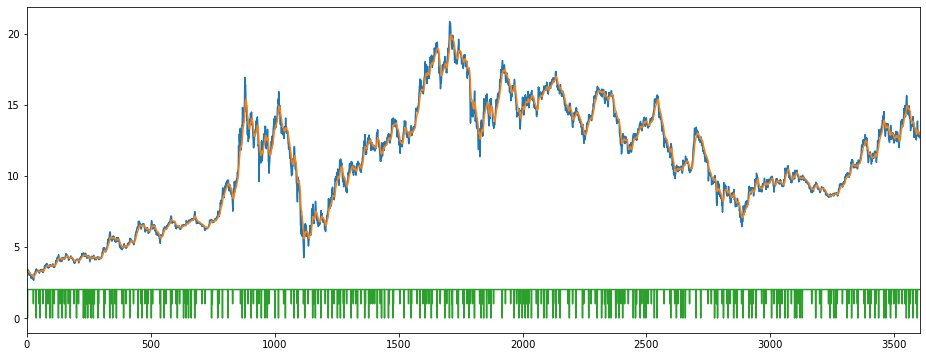

In [134]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [135]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [136]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [137]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [139]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3590, 64, 64, 1)

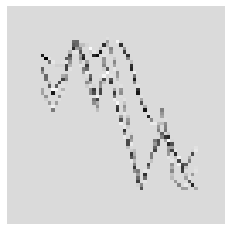

In [140]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [141]:
X = X/255

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}
Epoch 1/200
23/23 [==============================] - 4s 183ms/step - loss: 0.2582 - accuracy: 0.4345 - mse: 1.6929 - weighted_accuracy: 0.3598 - weighted_mse: 1.7488 - val_loss: 0.2309 - val_accuracy: 0.0460 - val_mse: 1.1549 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.1549
Epoch 2/200
23/23 [==============================] - 0s 20ms/step - loss: 0.2113 - accuracy: 0.3520 - mse: 1.3132 - weighted_accuracy: 0.3275 - weighted_mse: 1.2833 - val_loss: 0.1971 - val_accuracy: 0.0460 - val_mse: 1.0254 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.0254
Epoch 3/200
23/23 [==============================] - 0s 21ms/step - loss: 0.2045 - accuracy: 0.2688 - mse: 1.1677 - weighted_accuracy: 0.3204 - weighted_mse: 1.1715 - val_loss: 0.2193 - val_accuracy: 0.0460 - val_mse: 0.9766 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 0.9766
Epoch 4/200
23/23 [==============================] - 0s 21ms/step - loss: 0.20

23/23 [==============================] - 1s 30ms/step - loss: 0.1987 - accuracy: 0.3026 - mse: 1.1711 - weighted_accuracy: 0.3847 - weighted_mse: 1.1542 - val_loss: 0.1985 - val_accuracy: 0.0599 - val_mse: 0.9554 - val_weighted_accuracy: 0.0599 - val_weighted_mse: 0.9554
Epoch 29/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1985 - accuracy: 0.2838 - mse: 1.2058 - weighted_accuracy: 0.3700 - weighted_mse: 1.2196 - val_loss: 0.2004 - val_accuracy: 0.0738 - val_mse: 0.9062 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 0.9062
Epoch 30/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1980 - accuracy: 0.2657 - mse: 1.1394 - weighted_accuracy: 0.3611 - weighted_mse: 1.1395 - val_loss: 0.2016 - val_accuracy: 0.0696 - val_mse: 0.9380 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 0.9380
Epoch 31/200
23/23 [==============================] - 1s 35ms/step - loss: 0.1955 - accuracy: 0.2782 - mse: 1.1829 - weighted_accuracy: 0.3993 - weighted_mse:

Epoch 57/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1869 - accuracy: 0.2019 - mse: 1.2501 - weighted_accuracy: 0.4417 - weighted_mse: 1.2371 - val_loss: 0.1997 - val_accuracy: 0.0710 - val_mse: 0.9802 - val_weighted_accuracy: 0.0710 - val_weighted_mse: 0.9802
Epoch 58/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1850 - accuracy: 0.1814 - mse: 1.2286 - weighted_accuracy: 0.4797 - weighted_mse: 1.2406 - val_loss: 0.1998 - val_accuracy: 0.0669 - val_mse: 0.9530 - val_weighted_accuracy: 0.0669 - val_weighted_mse: 0.9530
Epoch 59/200
23/23 [==============================] - 1s 29ms/step - loss: 0.1858 - accuracy: 0.1943 - mse: 1.2104 - weighted_accuracy: 0.4652 - weighted_mse: 1.1847 - val_loss: 0.1964 - val_accuracy: 0.0780 - val_mse: 1.1199 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 1.1199
Epoch 60/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1842 - accuracy: 0.1783 - mse: 1.2504 - weighted_accuracy: 0.4931 - 

Epoch 86/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1711 - accuracy: 0.1818 - mse: 1.3250 - weighted_accuracy: 0.5376 - weighted_mse: 1.2805 - val_loss: 0.1985 - val_accuracy: 0.1393 - val_mse: 1.1560 - val_weighted_accuracy: 0.1393 - val_weighted_mse: 1.1560
Epoch 87/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1726 - accuracy: 0.1591 - mse: 1.3252 - weighted_accuracy: 0.5196 - weighted_mse: 1.2895 - val_loss: 0.1987 - val_accuracy: 0.1017 - val_mse: 1.1192 - val_weighted_accuracy: 0.1017 - val_weighted_mse: 1.1192
Epoch 88/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1708 - accuracy: 0.1640 - mse: 1.3296 - weighted_accuracy: 0.5502 - weighted_mse: 1.2909 - val_loss: 0.1978 - val_accuracy: 0.1184 - val_mse: 1.1836 - val_weighted_accuracy: 0.1184 - val_weighted_mse: 1.1836
Epoch 89/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1688 - accuracy: 0.1741 - mse: 1.3738 - weighted_accuracy: 0.5396 - 

Epoch 115/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1519 - accuracy: 0.2274 - mse: 1.4636 - weighted_accuracy: 0.6245 - weighted_mse: 1.4535 - val_loss: 0.1971 - val_accuracy: 0.1880 - val_mse: 1.3611 - val_weighted_accuracy: 0.1880 - val_weighted_mse: 1.3611
Epoch 116/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1527 - accuracy: 0.2173 - mse: 1.4967 - weighted_accuracy: 0.6040 - weighted_mse: 1.4953 - val_loss: 0.1972 - val_accuracy: 0.1880 - val_mse: 1.3326 - val_weighted_accuracy: 0.1880 - val_weighted_mse: 1.3326
Epoch 117/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1547 - accuracy: 0.2124 - mse: 1.4805 - weighted_accuracy: 0.6167 - weighted_mse: 1.4832 - val_loss: 0.1942 - val_accuracy: 0.1755 - val_mse: 1.3155 - val_weighted_accuracy: 0.1755 - val_weighted_mse: 1.3155
Epoch 118/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1550 - accuracy: 0.2166 - mse: 1.4524 - weighted_accuracy: 0.593

Epoch 144/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1434 - accuracy: 0.2591 - mse: 1.6810 - weighted_accuracy: 0.6388 - weighted_mse: 1.7538 - val_loss: 0.1952 - val_accuracy: 0.2479 - val_mse: 1.5121 - val_weighted_accuracy: 0.2479 - val_weighted_mse: 1.5121
Epoch 145/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1475 - accuracy: 0.2730 - mse: 1.6546 - weighted_accuracy: 0.6340 - weighted_mse: 1.6871 - val_loss: 0.1936 - val_accuracy: 0.2646 - val_mse: 1.4706 - val_weighted_accuracy: 0.2646 - val_weighted_mse: 1.4706
Epoch 146/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1422 - accuracy: 0.2674 - mse: 1.6813 - weighted_accuracy: 0.6489 - weighted_mse: 1.7734 - val_loss: 0.1925 - val_accuracy: 0.2618 - val_mse: 1.5082 - val_weighted_accuracy: 0.2618 - val_weighted_mse: 1.5082
Epoch 147/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1413 - accuracy: 0.2754 - mse: 1.6687 - weighted_accuracy: 0.647

23/23 [==============================] - 1s 32ms/step - loss: 0.1358 - accuracy: 0.3489 - mse: 1.8438 - weighted_accuracy: 0.6763 - weighted_mse: 2.0551 - val_loss: 0.1856 - val_accuracy: 0.3538 - val_mse: 1.5888 - val_weighted_accuracy: 0.3538 - val_weighted_mse: 1.5888
Epoch 173/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1350 - accuracy: 0.3538 - mse: 1.8540 - weighted_accuracy: 0.6879 - weighted_mse: 2.0055 - val_loss: 0.1854 - val_accuracy: 0.3593 - val_mse: 1.6663 - val_weighted_accuracy: 0.3593 - val_weighted_mse: 1.6663
Epoch 174/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1387 - accuracy: 0.3593 - mse: 1.7936 - weighted_accuracy: 0.6607 - weighted_mse: 1.9531 - val_loss: 0.1865 - val_accuracy: 0.3719 - val_mse: 1.6655 - val_weighted_accuracy: 0.3719 - val_weighted_mse: 1.6655
Epoch 175/200
23/23 [==============================] - 1s 29ms/step - loss: 0.1315 - accuracy: 0.3649 - mse: 1.9229 - weighted_accuracy: 0.6870 - weighted_m

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.17176347970962524
Test accuracy: 0.4916434586048126


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1706896  -0.9375716  -0.49316493]
 [ 0.16886508 -2.4442964  -0.79675317]
 [-1.6154553  -0.8913159  -0.37406936]
 ...
 [-2.896877    0.17946665 -0.856398  ]
 [-0.81704915 -1.1051781  -0.50673825]
 [-1.6289903  -0.84713745 -0.37626782]]


Counter({2: 346, 0: 231, 1: 141})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 17
actual buys but predicted sell: 2
actual buys but predicted hold: 13
actual sells but predicted buy: 2
actual predicted sells: 17
actual sells but predicted hold: 14
actual holds but predicted buy: 122
actual holds but predicted sell: 212
actual predicted holds: 319
Percentage buys correct: 53.125%
Percentage sells correct: 51.515151515151516%
Percentage holds correct: 48.85145482388974%
actual buys: 32
actual sells: 33
actual holds: 653


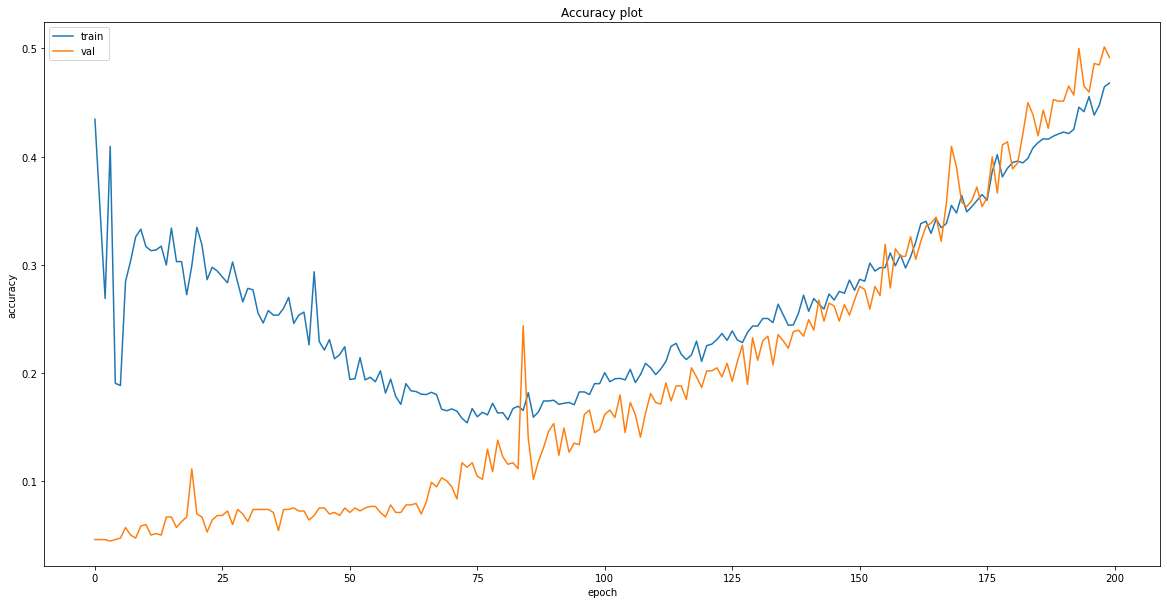

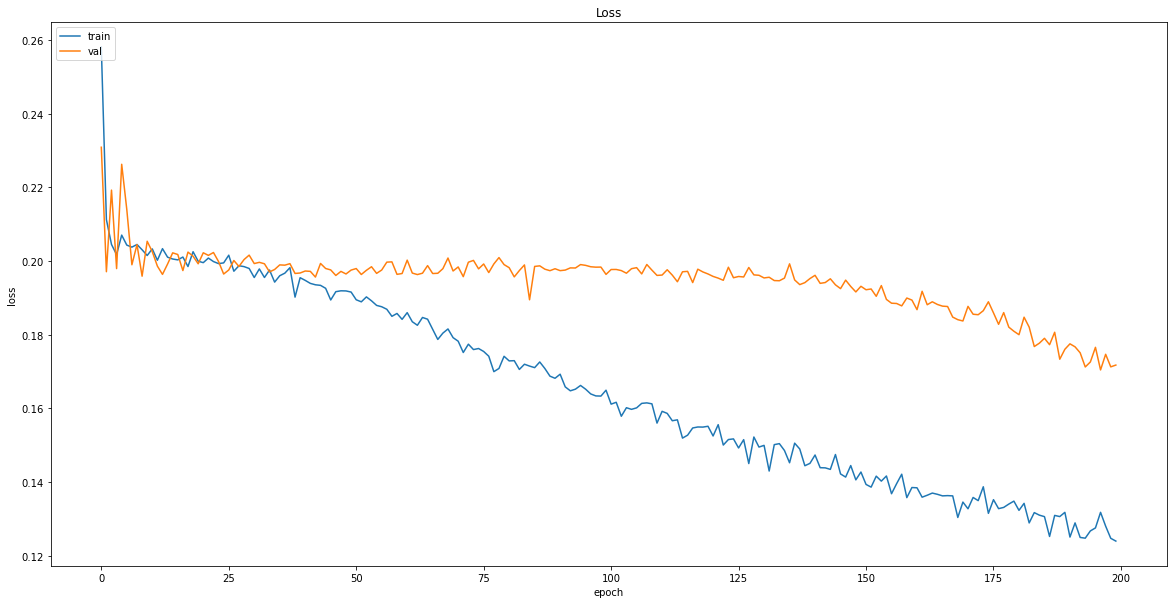

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

#### Non-Recession

In [153]:
logger = []

In [154]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


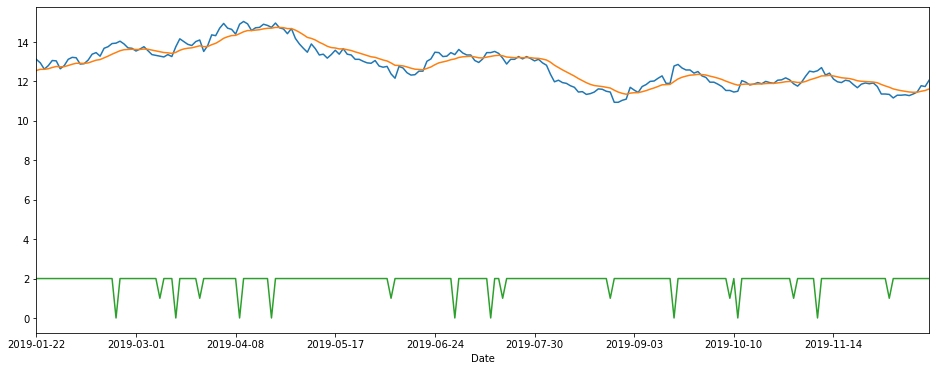

In [155]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [156]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [158]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [159]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [160]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1746 - accuracy: 0.4313 - mean_squared_error: 1.8299 - weighted_accuracy: 0.4313 - weighted_mean_squared_error: 1.8299
Test loss: 0.17459973692893982
Test accuracy: 0.43127962946891785


In [161]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 56, 2: 97, 1: 58})

In [162]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [163]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [164]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            0       2  
2019-02-15            0       2  
2019-02-18            2       2  
2019-02-19            0       2  
2019-02-20            0       2

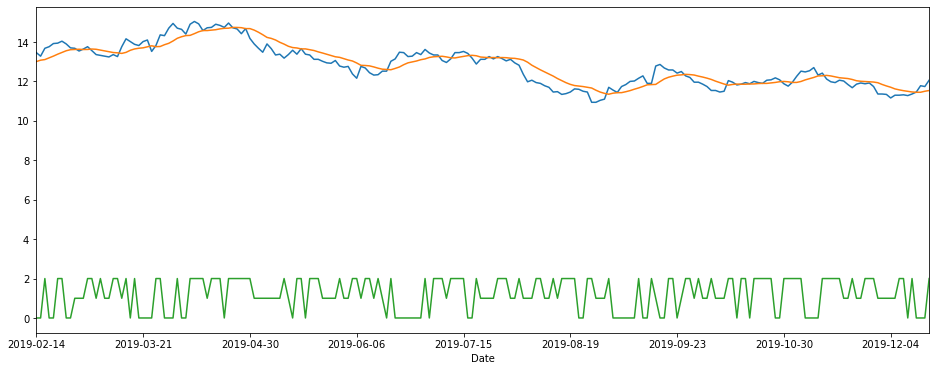

In [165]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

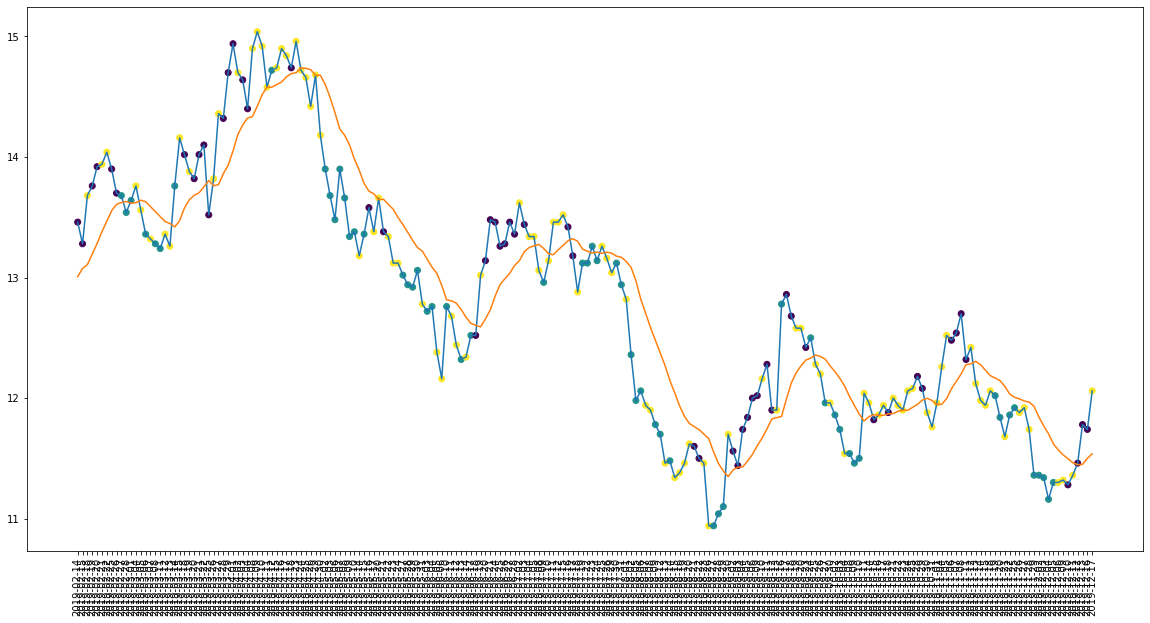

In [166]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

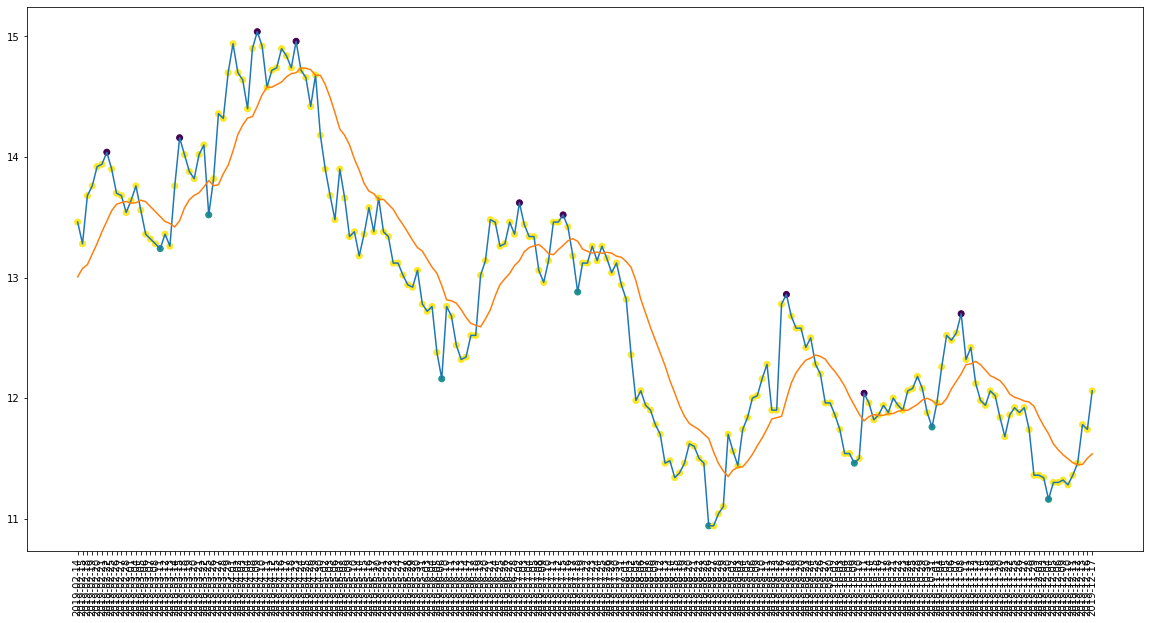

In [167]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [168]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 55
actual holds but predicted sell: 53
actual predicted holds: 86
Percentage buys correct: 37.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 44.329896907216494%
actual buys: 8
actual sells: 9
actual holds: 194


In [169]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 58.62068965517241%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 78.35051546391753%


In [170]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.279999732971193
Shares owned at the moment: 725
Cash capital at the moment: $0.3488574869643344


Price increase from previously bought: 5.282767116875209%
Share price: $14.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10136.89681345296


Share price: $14.720000267028807
Shares owned at the moment: 686
Cash capital at the moment: $11.207349767450069


Stop Loss Activated!

Share price: $14.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9711.93698854232


Share price: $13.899999618530273
Shares owned at the moment: 696
Cash capital at the moment: $10.932654775382616


Stop Loss Activated!

Share price: $13.479999542236328
Shares owned at the moment: 0
Cash capital at the 

In [171]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [172]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells  \
0       0.637615  44.44444444444444%   55.55555555555556%   
1       0.623256               62.5%  33.333333333333336%   
2       0.674312               37.5%   55.55555555555556%   
3       0.753488               25.0%                60.0%   
4       0.431280               37.5%   22.22222222222222%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%

### Recession

In [173]:
logger = []

In [174]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [175]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [177]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [178]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [179]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.5023 - mean_squared_error: 1.7963 - weighted_accuracy: 0.5023 - weighted_mean_squared_error: 1.7963
Test loss: 0.1663968861103058
Test accuracy: 0.5023474097251892


In [180]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 59, 1: 58, 2: 96})

In [181]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [182]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [183]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            0       2  
2020-02-14            0       2  
2020-02-17            1       2  
2020-02-18            0       2  
2020-02-19            2       2

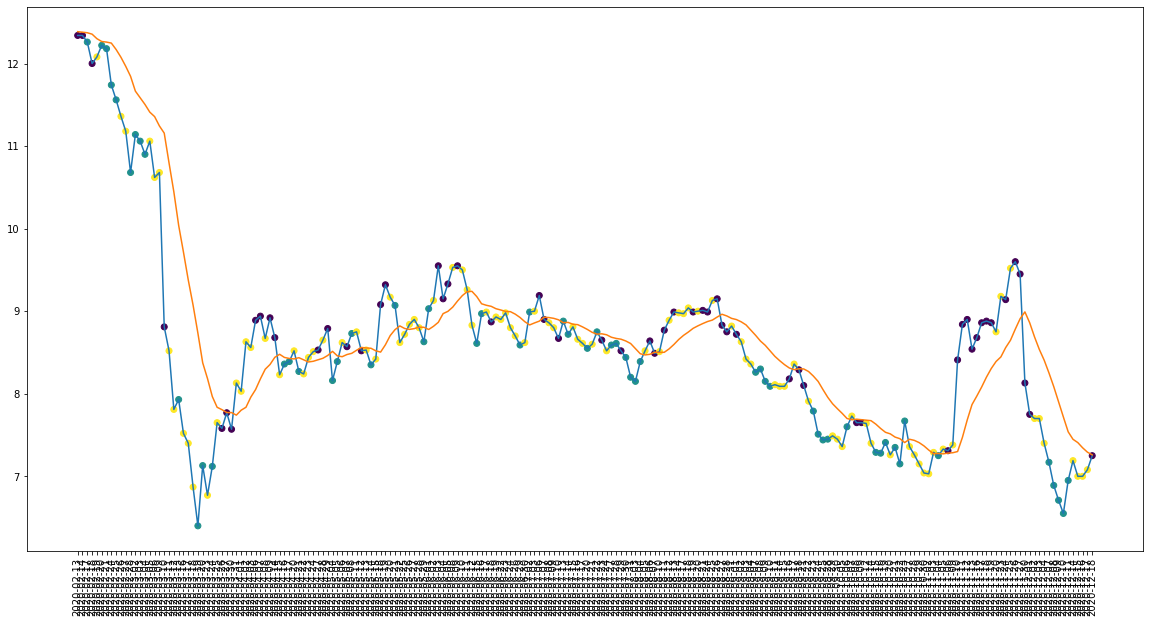

In [184]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

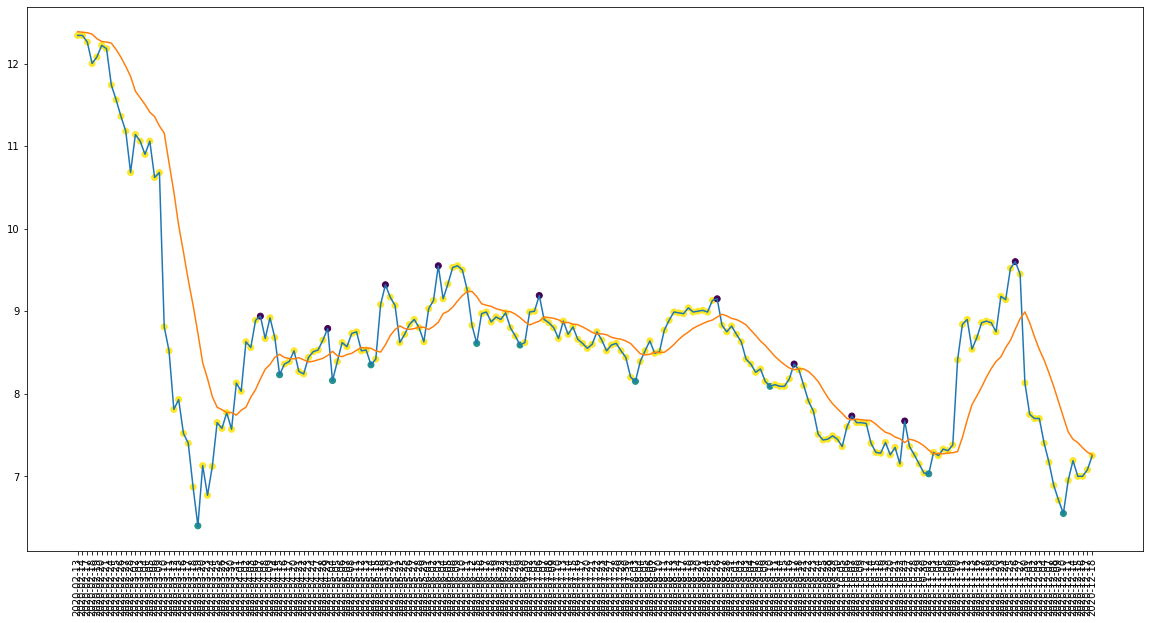

In [185]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [186]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 49
actual holds but predicted sell: 52
actual predicted holds: 92
Percentage buys correct: 80.0%
Percentage sells correct: 70.0%
Percentage holds correct: 47.66839378238342%
actual buys: 10
actual sells: 10
actual holds: 193


In [187]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 48.275862068965516%
Percentage sells correct: 58.62068965517241%
Percentage holds correct: 88.54166666666667%


In [188]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.260000228881836
Shares owned at the moment: 813
Cash capital at the moment: $5.209518407344149


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9523.581627838133


Share price: $11.739999771118164
Shares owned at the moment: 808
Cash capital at the moment: $11.57553328323229


Stop Loss Activated!

Share price: $11.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $9165.213336641309


Share price: $10.68000030517578
Shares owned at the moment: 855
Cash capital at the moment: $8.701724998472855


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7520.537570284127


Share price: $7.929999828338622
Shares owned at the moment: 945
Cash capital at the moment: $6.079645450233329


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7092.9370274753555


Share price: 

In [189]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [190]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells  \
0       0.637615  44.44444444444444%   55.55555555555556%   
1       0.623256               62.5%  33.333333333333336%   
2       0.674312               37.5%   55.55555555555556%   
3       0.753488               25.0%                60.0%   
4       0.431280               37.5%   22.22222222222222%   
5       0.502347               80.0%                70.0%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   
5   47.66839378238342%  48.275862068965516%  58.62068965517241%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%  
5  88.54166666666667%   -6.716807591142733%   -41.56249103630067%

## #jP Morgan

In [191]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


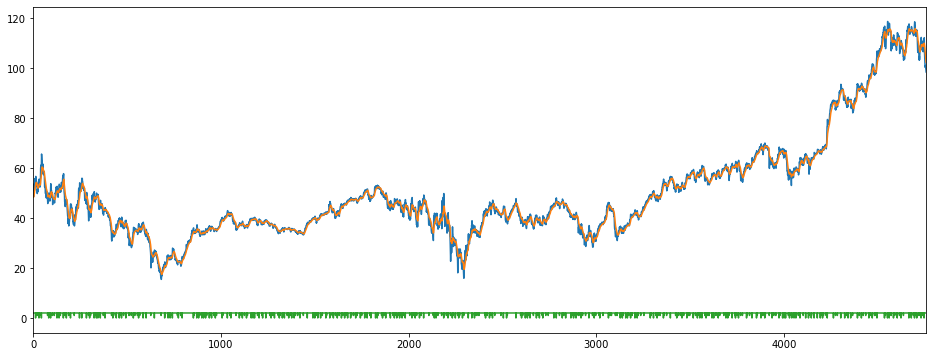

In [192]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [193]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [194]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [195]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [197]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

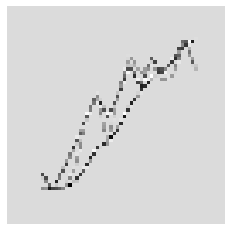

In [198]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [199]:
X = X/255

In [200]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [201]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [202]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [204]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 5s 166ms/step - loss: 0.2485 - accuracy: 0.4241 - mse: 1.6344 - weighted_accuracy: 0.3156 - weighted_mse: 1.7671 - val_loss: 0.1837 - val_accuracy: 0.9104 - val_mse: 0.9823 - val_weighted_accuracy: 0.9104 - val_weighted_mse: 0.9823
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 0.2042 - accuracy: 0.3072 - mse: 1.2118 - weighted_accuracy: 0.3282 - weighted_mse: 1.1999 - val_loss: 0.2039 - val_accuracy: 0.0432 - val_mse: 0.9589 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.9589
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 0.2032 - accuracy: 0.3224 - mse: 1.1774 - weighted_accuracy: 0.3373 - weighted_mse: 1.1762 - val_loss: 0.1815 - val_accuracy: 0.9104 - val_mse: 0.7907 - val_weighted_accuracy: 0.9104 - val_weighted_mse: 0.7907
Epoch 4/200
30/30 [==============================] - 1s 21ms/step - loss: 0.2

30/30 [==============================] - 1s 34ms/step - loss: 0.1937 - accuracy: 0.2590 - mse: 1.2392 - weighted_accuracy: 0.4394 - weighted_mse: 1.1979 - val_loss: 0.1941 - val_accuracy: 0.1675 - val_mse: 0.9608 - val_weighted_accuracy: 0.1675 - val_weighted_mse: 0.9608
Epoch 29/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1916 - accuracy: 0.3148 - mse: 1.2165 - weighted_accuracy: 0.4384 - weighted_mse: 1.2036 - val_loss: 0.1987 - val_accuracy: 0.1001 - val_mse: 0.9904 - val_weighted_accuracy: 0.1001 - val_weighted_mse: 0.9904
Epoch 30/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1922 - accuracy: 0.3064 - mse: 1.1960 - weighted_accuracy: 0.4262 - weighted_mse: 1.2004 - val_loss: 0.1943 - val_accuracy: 0.1781 - val_mse: 0.9742 - val_weighted_accuracy: 0.1781 - val_weighted_mse: 0.9742
Epoch 31/200
30/30 [==============================] - 1s 36ms/step - loss: 0.1900 - accuracy: 0.2484 - mse: 1.2323 - weighted_accuracy: 0.4448 - weighted_mse:

30/30 [==============================] - 1s 30ms/step - loss: 0.1727 - accuracy: 0.2221 - mse: 1.3679 - weighted_accuracy: 0.5720 - weighted_mse: 1.3319 - val_loss: 0.1917 - val_accuracy: 0.1444 - val_mse: 1.2452 - val_weighted_accuracy: 0.1444 - val_weighted_mse: 1.2452
Epoch 57/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1734 - accuracy: 0.2323 - mse: 1.3747 - weighted_accuracy: 0.5439 - weighted_mse: 1.3141 - val_loss: 0.1943 - val_accuracy: 0.1401 - val_mse: 1.1414 - val_weighted_accuracy: 0.1401 - val_weighted_mse: 1.1414
Epoch 58/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1685 - accuracy: 0.2173 - mse: 1.3820 - weighted_accuracy: 0.5674 - weighted_mse: 1.3691 - val_loss: 0.1966 - val_accuracy: 0.1264 - val_mse: 1.2265 - val_weighted_accuracy: 0.1264 - val_weighted_mse: 1.2265
Epoch 59/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1736 - accuracy: 0.2508 - mse: 1.3830 - weighted_accuracy: 0.5240 - weighted_mse:

Epoch 85/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1558 - accuracy: 0.2806 - mse: 1.5580 - weighted_accuracy: 0.6225 - weighted_mse: 1.5316 - val_loss: 0.1903 - val_accuracy: 0.2150 - val_mse: 1.2686 - val_weighted_accuracy: 0.2150 - val_weighted_mse: 1.2686
Epoch 86/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1550 - accuracy: 0.2813 - mse: 1.4998 - weighted_accuracy: 0.5996 - weighted_mse: 1.4707 - val_loss: 0.1921 - val_accuracy: 0.2223 - val_mse: 1.2943 - val_weighted_accuracy: 0.2223 - val_weighted_mse: 1.2943- accuracy: 0.2813 - mse: 1.4998 - weighted_accuracy: 0.5996 - weighted_mse: 1.470
Epoch 87/200
30/30 [==============================] - 1s 36ms/step - loss: 0.1567 - accuracy: 0.2919 - mse: 1.4960 - weighted_accuracy: 0.6041 - weighted_mse: 1.4656 - val_loss: 0.1905 - val_accuracy: 0.2013 - val_mse: 1.2471 - val_weighted_accuracy: 0.2013 - val_weighted_mse: 1.2471
Epoch 88/200
30/30 [==============================] - 1s 32ms/s

30/30 [==============================] - 1s 34ms/step - loss: 0.1415 - accuracy: 0.3622 - mse: 1.6480 - weighted_accuracy: 0.6692 - weighted_mse: 1.6888 - val_loss: 0.1905 - val_accuracy: 0.2750 - val_mse: 1.5151 - val_weighted_accuracy: 0.2750 - val_weighted_mse: 1.5151
Epoch 114/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1430 - accuracy: 0.3780 - mse: 1.6735 - weighted_accuracy: 0.6580 - weighted_mse: 1.7560 - val_loss: 0.1817 - val_accuracy: 0.3572 - val_mse: 1.3474 - val_weighted_accuracy: 0.3572 - val_weighted_mse: 1.3474
Epoch 115/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1399 - accuracy: 0.3725 - mse: 1.6460 - weighted_accuracy: 0.6652 - weighted_mse: 1.7535 - val_loss: 0.1714 - val_accuracy: 0.4731 - val_mse: 1.4503 - val_weighted_accuracy: 0.4731 - val_weighted_mse: 1.4503
Epoch 116/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1412 - accuracy: 0.3859 - mse: 1.6831 - weighted_accuracy: 0.6685 - weighted_m

Epoch 142/200
30/30 [==============================] - 1s 36ms/step - loss: 0.1264 - accuracy: 0.4776 - mse: 1.8393 - weighted_accuracy: 0.7183 - weighted_mse: 2.0239 - val_loss: 0.1746 - val_accuracy: 0.4963 - val_mse: 1.6748 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 1.6748
Epoch 143/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1238 - accuracy: 0.4797 - mse: 1.8913 - weighted_accuracy: 0.7287 - weighted_mse: 2.0768 - val_loss: 0.1697 - val_accuracy: 0.5153 - val_mse: 1.5227 - val_weighted_accuracy: 0.5153 - val_weighted_mse: 1.5227
Epoch 144/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1270 - accuracy: 0.4921 - mse: 1.8572 - weighted_accuracy: 0.7220 - weighted_mse: 2.0230 - val_loss: 0.1686 - val_accuracy: 0.5258 - val_mse: 1.5245 - val_weighted_accuracy: 0.5258 - val_weighted_mse: 1.5245
Epoch 145/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1265 - accuracy: 0.4887 - mse: 1.8810 - weighted_accuracy: 0.720

Epoch 171/200
30/30 [==============================] - 1s 42ms/step - loss: 0.1073 - accuracy: 0.6054 - mse: 2.1834 - weighted_accuracy: 0.7881 - weighted_mse: 2.6411 - val_loss: 0.1465 - val_accuracy: 0.6786 - val_mse: 1.7061 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 1.7061
Epoch 172/200
30/30 [==============================] - 1s 43ms/step - loss: 0.1072 - accuracy: 0.6180 - mse: 2.1575 - weighted_accuracy: 0.8140 - weighted_mse: 2.6026 - val_loss: 0.1662 - val_accuracy: 0.5511 - val_mse: 1.7475 - val_weighted_accuracy: 0.5511 - val_weighted_mse: 1.7475
Epoch 173/200
30/30 [==============================] - 1s 44ms/step - loss: 0.1053 - accuracy: 0.6038 - mse: 2.1617 - weighted_accuracy: 0.8069 - weighted_mse: 2.6586 - val_loss: 0.1445 - val_accuracy: 0.6797 - val_mse: 1.7489 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 1.7489
Epoch 174/200
30/30 [==============================] - 1s 39ms/step - loss: 0.1076 - accuracy: 0.6170 - mse: 2.1577 - weighted_accuracy: 0.800

Epoch 200/200
30/30 [==============================] - 1s 24ms/step - loss: 0.0896 - accuracy: 0.6781 - mse: 2.6203 - weighted_accuracy: 0.8379 - weighted_mse: 3.4762 - val_loss: 0.1305 - val_accuracy: 0.7555 - val_mse: 1.9117 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 1.9117


In [205]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1305164247751236
Test accuracy: 0.7555321455001831


In [206]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.81543297 -1.8658683  -0.04696156]
 [-0.84500366 -1.6213201  -0.05451285]
 [-0.22302592 -2.3381677  -0.4748385 ]
 ...
 [-1.0909436  -1.3404154   0.05222135]
 [-1.0568178  -1.1384329  -0.17536789]
 [-0.5965821  -2.3868332  -0.11751335]]


Counter({2: 777, 0: 105, 1: 67})

In [207]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [208]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 33
actual holds but predicted buy: 62
actual holds but predicted sell: 97
actual predicted holds: 706
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 17.073170731707318%
Percentage holds correct: 81.61849710982659%
actual buys: 43
actual sells: 41
actual holds: 865


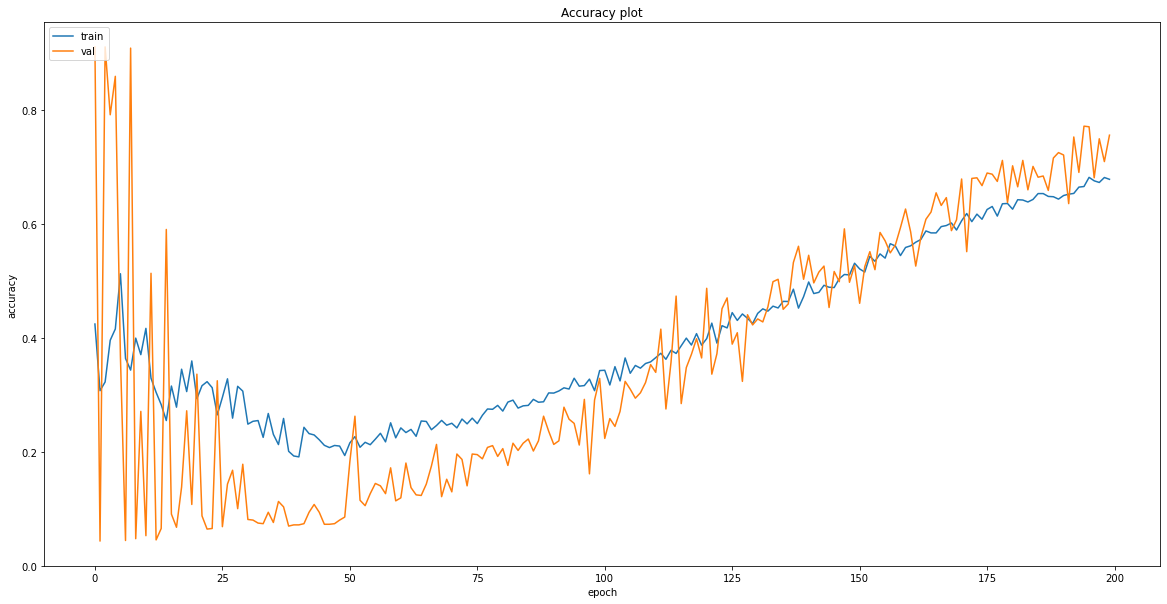

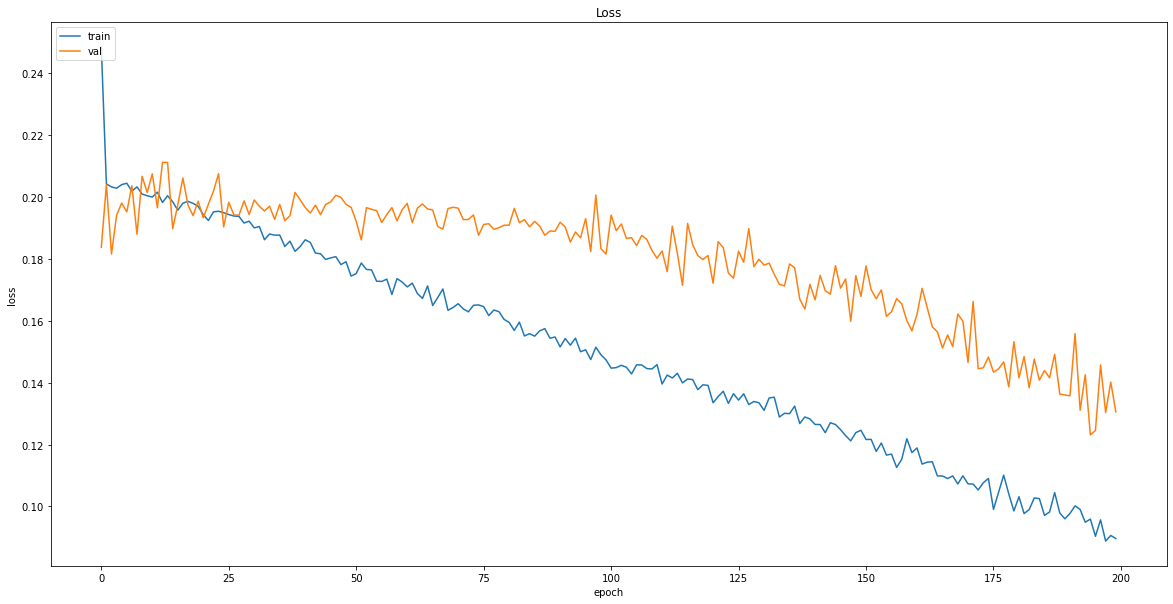

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [210]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [211]:
logger = []

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [213]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [215]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [216]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [217]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 6ms/step - loss: 0.1267 - accuracy: 0.7202 - mean_squared_error: 1.9416 - weighted_accuracy: 0.7202 - weighted_mean_squared_error: 1.9416
Test loss: 0.1267484873533249
Test accuracy: 0.7201834917068481


In [218]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 0: 27, 1: 25})

In [219]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [220]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [221]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

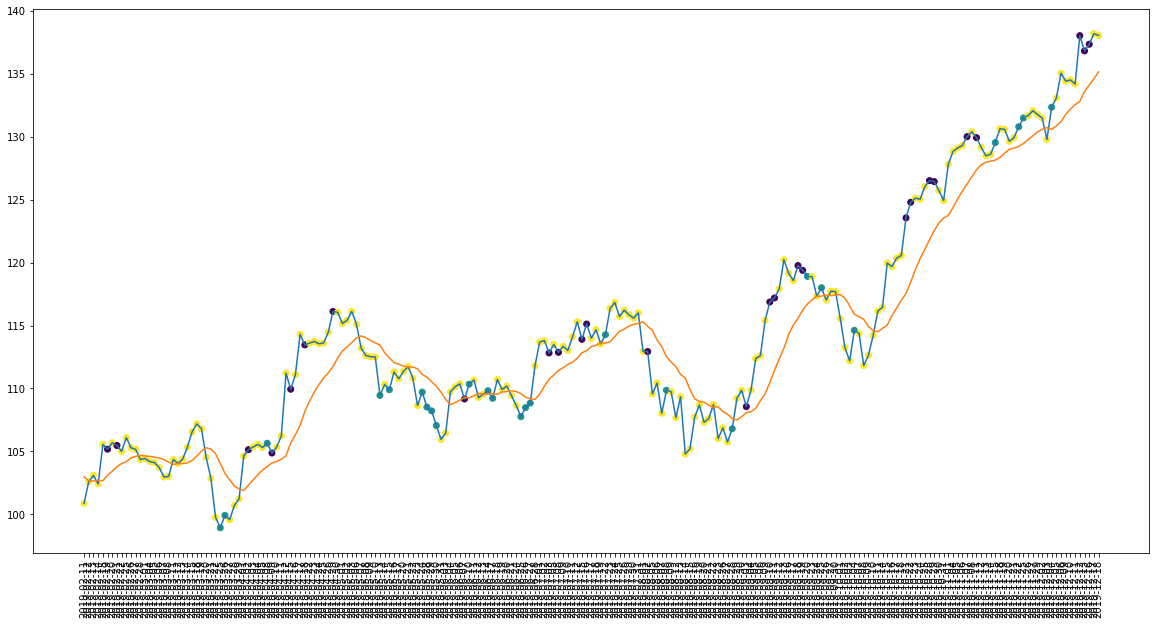

In [222]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

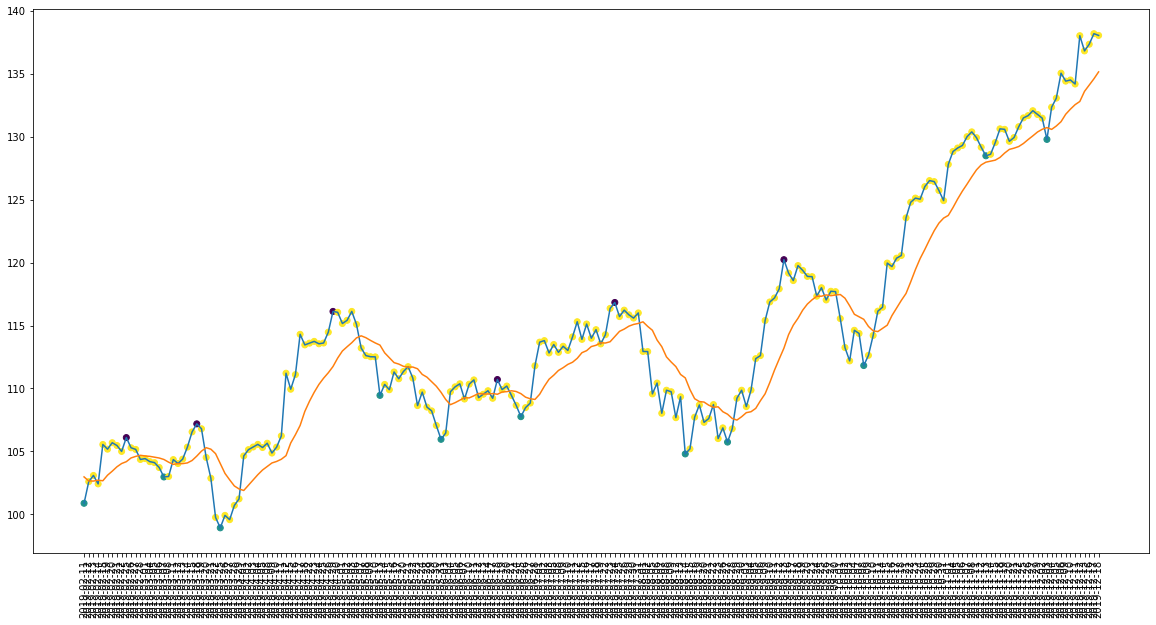

In [223]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [224]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 22
actual holds but predicted sell: 26
actual predicted holds: 153
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 76.11940298507463%
actual buys: 11
actual sells: 6
actual holds: 201


In [225]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 56.0%
Percentage sells correct: 40.74074074074074%
Percentage holds correct: 84.84848484848484%


In [226]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.93000030517578
Shares owned at the moment: 100
Cash capital at the moment: $79.79421939849817


Price increase from previously bought: 5.98570404178993%
Share price: $105.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10564.880658531189


Share price: $105.6500015258789
Shares owned at the moment: 99
Cash capital at the moment: $76.76729455375607


Price increase from previously bought: 7.097811775587548%
Share price: $113.45999908447266
Shares owned at the moment: 0
Cash capital at the moment: $11278.417719165802


Share price: $109.4499969482422
Shares owned at the moment: 102
Cash capital at the moment: $83.81730630111451


Stop Loss Activated!

Share price: $105.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $10862.01543317413


Share price: $110.33999633789062
Shares owned at the moment: 98
Cash capital at the moment: $18.959163047788024


Stop Loss Activated!

Share price: $104.8000030517578
Shares owned at the

In [227]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [228]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.637615   44.44444444444444%   55.55555555555556%   
1       0.623256                62.5%  33.333333333333336%   
2       0.674312                37.5%   55.55555555555556%   
3       0.753488                25.0%                60.0%   
4       0.431280                37.5%   22.22222222222222%   
5       0.502347                80.0%                70.0%   
6       0.720183  27.272727272727273%  16.666666666666668%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   
5   47.66839378238342%  48.275862068965516%  58.62068965517241%   
6   76.11940298507463%                56.0%  40.74074074074074%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%  
5  88.54166666666667%   -6.716807591142733%   -41.56249103630067%  
6  84.84848484848484%    22.39773028585425%    35.77290673755644%

### recession

In [229]:
logger = []

In [230]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [231]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [232]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [233]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [234]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [235]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 11ms/step - loss: 0.1271 - accuracy: 0.7534 - mean_squared_error: 1.9848 - weighted_accuracy: 0.7534 - weighted_mean_squared_error: 1.9848
Test loss: 0.12709414958953857
Test accuracy: 0.7534246444702148


In [236]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 0: 17, 1: 17})

In [237]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [238]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [239]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            0       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

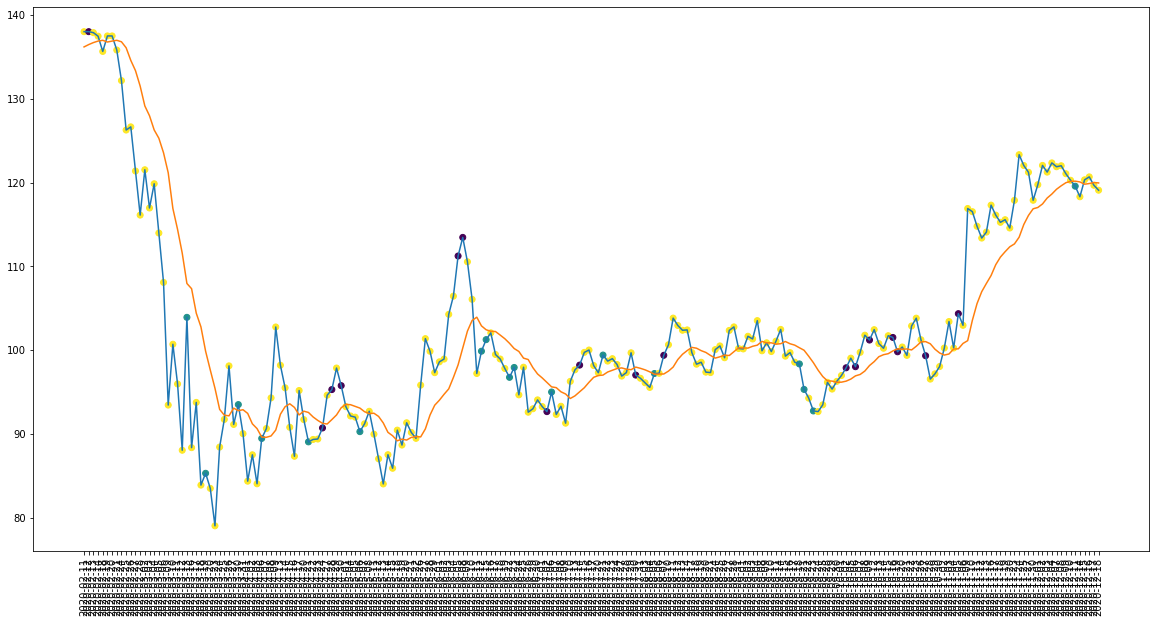

In [240]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

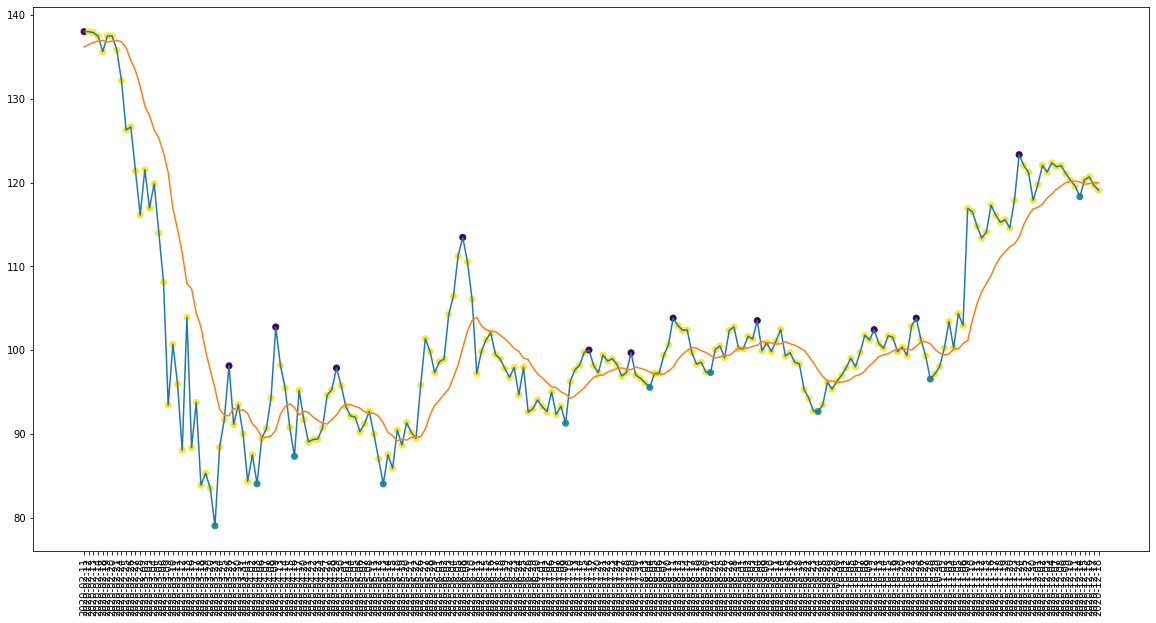

In [241]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [242]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 17
actual holds but predicted sell: 16
actual predicted holds: 164
Percentage buys correct: 0.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 83.248730964467%
actual buys: 10
actual sells: 12
actual holds: 197


In [243]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 47.05882352941177%
Percentage sells correct: 52.94117647058823%
Percentage holds correct: 80.97826086956522%


In [244]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $103.91000366210938
Shares owned at the moment: 95
Cash capital at the moment: $101.40316364288265


Stop Loss Activated!

Share price: $88.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8472.519171466827


Share price: $85.30000305175781
Shares owned at the moment: 99
Cash capital at the moment: $4.595943511962105


Stop Loss Activated!

Share price: $79.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $7807.049905494689


Share price: $93.5
Shares owned at the moment: 83
Cash capital at the moment: $25.208530494688603


Stop Loss Activated!

Share price: $90.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $7477.149081954954


Share price: $89.45999908447266
Shares owned at the moment: 83
Cash capital at the moment: $31.54991315269308


Price increase from previously bought: 6.224763067134909%
Share price: $95.29000091552734
Shares owned at the moment: 0
Cash capital at the moment: $7918.870046432

In [245]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [246]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.637615   44.44444444444444%   55.55555555555556%   
1       0.623256                62.5%  33.333333333333336%   
2       0.674312                37.5%   55.55555555555556%   
3       0.753488                25.0%                60.0%   
4       0.431280                37.5%   22.22222222222222%   
5       0.502347                80.0%                70.0%   
6       0.720183  27.272727272727273%  16.666666666666668%   
7       0.753425                 0.0%   8.333333333333334%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   
5   47.66839378238342%  48.275862068965516%  58.62068965517241%   
6   76.11940298507463%                56.0%  40.74074074074074%   
7     83.248730964467%   47.05882352941177%  52.94117647058823%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%  
5  88.54166666666667%   -6.716807591142733%   -41.56249103630067%  
6  84.84848484848484%    22.39773028585425%    35.77290673755644%  
7  80.97826086956522%  -34.673518536567755%   -14.13141708526613%

## American Axle & Manufacturing Holdings, Inc

In [247]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


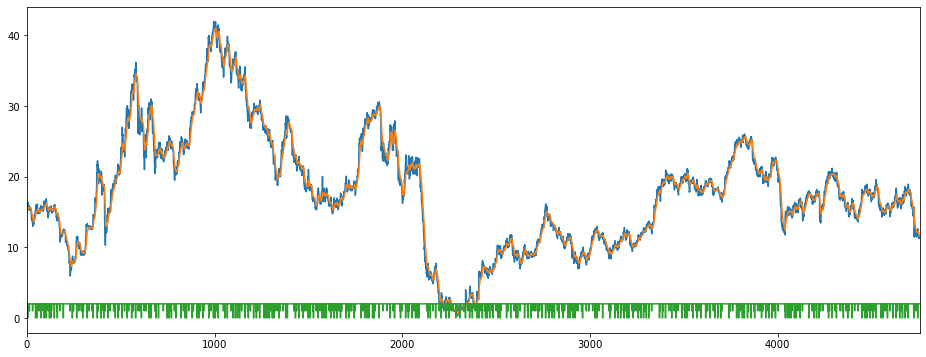

In [248]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [249]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [250]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [252]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

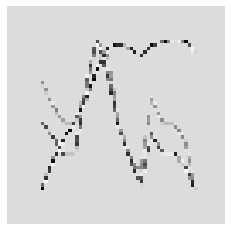

In [253]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [254]:
X = X/255

In [255]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [256]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [257]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [258]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [259]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}
Epoch 1/200
30/30 [==============================] - 5s 172ms/step - loss: 0.2450 - accuracy: 0.3793 - mse: 1.5796 - weighted_accuracy: 0.3163 - weighted_mse: 1.6446 - val_loss: 0.2151 - val_accuracy: 0.0432 - val_mse: 1.0010 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.0010
Epoch 2/200
30/30 [==============================] - 1s 21ms/step - loss: 0.2049 - accuracy: 0.3656 - mse: 1.2211 - weighted_accuracy: 0.3478 - weighted_mse: 1.2232 - val_loss: 0.2008 - val_accuracy: 0.8240 - val_mse: 0.7811 - val_weighted_accuracy: 0.8240 - val_weighted_mse: 0.7811
Epoch 3/200
30/30 [==============================] - 1s 21ms/step - loss: 0.2058 - accuracy: 0.4976 - mse: 1.1067 - weighted_accuracy: 0.3068 - weighted_mse: 1.1552 - val_loss: 0.2037 - val_accuracy: 0.0474 - val_mse: 0.9350 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.9350
Epoch 4/200
30/30 [==============================] - 1s 21ms/step - loss: 0.2

Epoch 28/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1990 - accuracy: 0.3496 - mse: 1.1866 - weighted_accuracy: 0.3490 - weighted_mse: 1.1803 - val_loss: 0.2033 - val_accuracy: 0.0727 - val_mse: 0.9181 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9181
Epoch 29/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1976 - accuracy: 0.3256 - mse: 1.1693 - weighted_accuracy: 0.3713 - weighted_mse: 1.1666 - val_loss: 0.1983 - val_accuracy: 0.0927 - val_mse: 0.9350 - val_weighted_accuracy: 0.0927 - val_weighted_mse: 0.9350
Epoch 30/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1978 - accuracy: 0.3230 - mse: 1.1859 - weighted_accuracy: 0.3904 - weighted_mse: 1.1798 - val_loss: 0.1977 - val_accuracy: 0.0611 - val_mse: 0.9714 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 0.9714
Epoch 31/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1970 - accuracy: 0.3048 - mse: 1.1925 - weighted_accuracy: 0.3491 - 

Epoch 57/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1847 - accuracy: 0.2521 - mse: 1.2464 - weighted_accuracy: 0.4775 - weighted_mse: 1.2308 - val_loss: 0.1918 - val_accuracy: 0.1528 - val_mse: 1.0433 - val_weighted_accuracy: 0.1528 - val_weighted_mse: 1.0433
Epoch 58/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1842 - accuracy: 0.2181 - mse: 1.2412 - weighted_accuracy: 0.4633 - weighted_mse: 1.2164 - val_loss: 0.1956 - val_accuracy: 0.0896 - val_mse: 1.0488 - val_weighted_accuracy: 0.0896 - val_weighted_mse: 1.0488
Epoch 59/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1849 - accuracy: 0.2184 - mse: 1.2384 - weighted_accuracy: 0.4413 - weighted_mse: 1.1976 - val_loss: 0.1941 - val_accuracy: 0.1286 - val_mse: 1.0202 - val_weighted_accuracy: 0.1286 - val_weighted_mse: 1.0202
Epoch 60/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1836 - accuracy: 0.2115 - mse: 1.2596 - weighted_accuracy: 0.4589 - 

Epoch 86/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1679 - accuracy: 0.2136 - mse: 1.4021 - weighted_accuracy: 0.5580 - weighted_mse: 1.3482 - val_loss: 0.1843 - val_accuracy: 0.2308 - val_mse: 1.2555 - val_weighted_accuracy: 0.2308 - val_weighted_mse: 1.2555
Epoch 87/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1650 - accuracy: 0.2100 - mse: 1.3636 - weighted_accuracy: 0.5750 - weighted_mse: 1.3359 - val_loss: 0.1904 - val_accuracy: 0.1918 - val_mse: 1.2554 - val_weighted_accuracy: 0.1918 - val_weighted_mse: 1.2554
Epoch 88/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1656 - accuracy: 0.2089 - mse: 1.3927 - weighted_accuracy: 0.5437 - weighted_mse: 1.3548 - val_loss: 0.1875 - val_accuracy: 0.2023 - val_mse: 1.2538 - val_weighted_accuracy: 0.2023 - val_weighted_mse: 1.2538
Epoch 89/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1664 - accuracy: 0.1928 - mse: 1.3884 - weighted_accuracy: 0.5506 - 

30/30 [==============================] - 1s 24ms/step - loss: 0.1507 - accuracy: 0.2582 - mse: 1.5761 - weighted_accuracy: 0.6184 - weighted_mse: 1.5183 - val_loss: 0.1856 - val_accuracy: 0.2961 - val_mse: 1.4503 - val_weighted_accuracy: 0.2961 - val_weighted_mse: 1.4503
Epoch 115/200
30/30 [==============================] - 1s 27ms/step - loss: 0.1478 - accuracy: 0.2734 - mse: 1.6332 - weighted_accuracy: 0.6405 - weighted_mse: 1.6031 - val_loss: 0.1872 - val_accuracy: 0.2255 - val_mse: 1.3365 - val_weighted_accuracy: 0.2255 - val_weighted_mse: 1.3365
Epoch 116/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1490 - accuracy: 0.2848 - mse: 1.5814 - weighted_accuracy: 0.6464 - weighted_mse: 1.5748 - val_loss: 0.1861 - val_accuracy: 0.2750 - val_mse: 1.4688 - val_weighted_accuracy: 0.2750 - val_weighted_mse: 1.4688
Epoch 117/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1494 - accuracy: 0.2713 - mse: 1.6157 - weighted_accuracy: 0.6178 - weighted_m

Epoch 143/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1344 - accuracy: 0.4099 - mse: 1.7846 - weighted_accuracy: 0.6942 - weighted_mse: 1.8492 - val_loss: 0.1804 - val_accuracy: 0.4067 - val_mse: 1.7399 - val_weighted_accuracy: 0.4067 - val_weighted_mse: 1.7399
Epoch 144/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1341 - accuracy: 0.4009 - mse: 1.8936 - weighted_accuracy: 0.6910 - weighted_mse: 1.9580 - val_loss: 0.1800 - val_accuracy: 0.4268 - val_mse: 1.7122 - val_weighted_accuracy: 0.4268 - val_weighted_mse: 1.7122
Epoch 145/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1328 - accuracy: 0.3830 - mse: 1.8887 - weighted_accuracy: 0.6825 - weighted_mse: 1.9548 - val_loss: 0.1757 - val_accuracy: 0.4131 - val_mse: 1.6042 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.6042
Epoch 146/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1295 - accuracy: 0.4265 - mse: 1.8760 - weighted_accuracy: 0.704

Epoch 172/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1191 - accuracy: 0.5203 - mse: 2.1222 - weighted_accuracy: 0.7439 - weighted_mse: 2.4130 - val_loss: 0.1619 - val_accuracy: 0.5448 - val_mse: 1.8615 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 1.8615
Epoch 173/200
30/30 [==============================] - 1s 20ms/step - loss: 0.1202 - accuracy: 0.5184 - mse: 2.1485 - weighted_accuracy: 0.7305 - weighted_mse: 2.4360 - val_loss: 0.1566 - val_accuracy: 0.5722 - val_mse: 1.8272 - val_weighted_accuracy: 0.5722 - val_weighted_mse: 1.8272
Epoch 174/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1139 - accuracy: 0.5190 - mse: 2.2165 - weighted_accuracy: 0.7561 - weighted_mse: 2.5949 - val_loss: 0.1616 - val_accuracy: 0.5416 - val_mse: 1.8351 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 1.8351
Epoch 175/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1149 - accuracy: 0.5195 - mse: 2.1690 - weighted_accuracy: 0.743

In [260]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1384025514125824
Test accuracy: 0.6828240156173706


In [261]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.0483193  -0.5244398  -0.36312222]
 [-0.5099488  -1.705395   -0.33428884]
 [-2.6631782   0.04144359 -0.77336735]
 ...
 [-1.2040361  -0.72186    -0.29822648]
 [-0.88984585 -1.5252614  -0.18074746]
 [-0.9220489  -1.3610022  -0.15166137]]


Counter({2: 667, 1: 193, 0: 89})

In [262]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [263]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 23
actual buys but predicted sell: 1
actual buys but predicted hold: 20
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 32
actual holds but predicted buy: 169
actual holds but predicted sell: 78
actual predicted holds: 615
Percentage buys correct: 52.27272727272727%
Percentage sells correct: 23.25581395348837%
Percentage holds correct: 71.34570765661253%
actual buys: 44
actual sells: 43
actual holds: 862


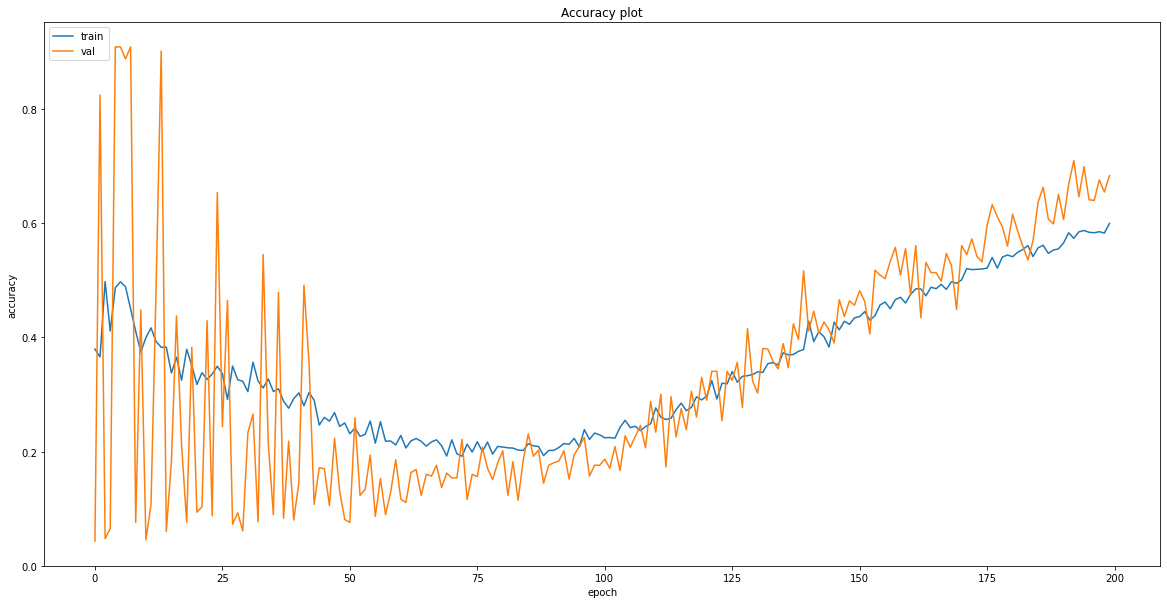

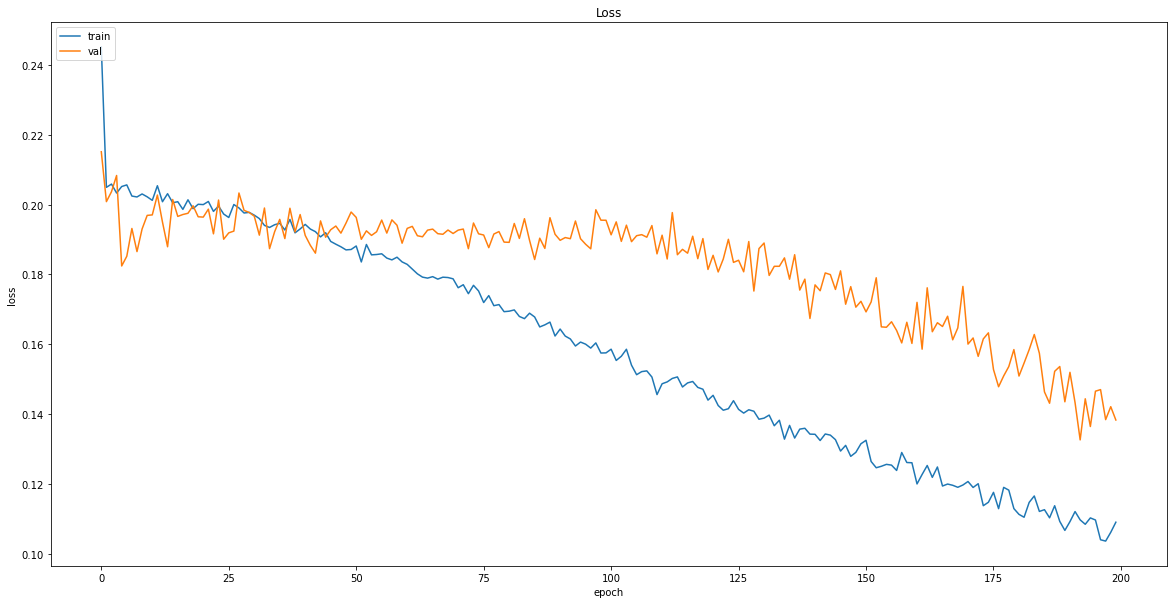

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [265]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [266]:
logger = []

In [267]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [268]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [269]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [270]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [271]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [272]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1481 - accuracy: 0.6330 - mean_squared_error: 2.0234 - weighted_accuracy: 0.6330 - weighted_mean_squared_error: 2.0234
Test loss: 0.148084357380867
Test accuracy: 0.6330274939537048


In [273]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 150, 1: 51, 0: 17})

In [274]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [275]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [276]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            1       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

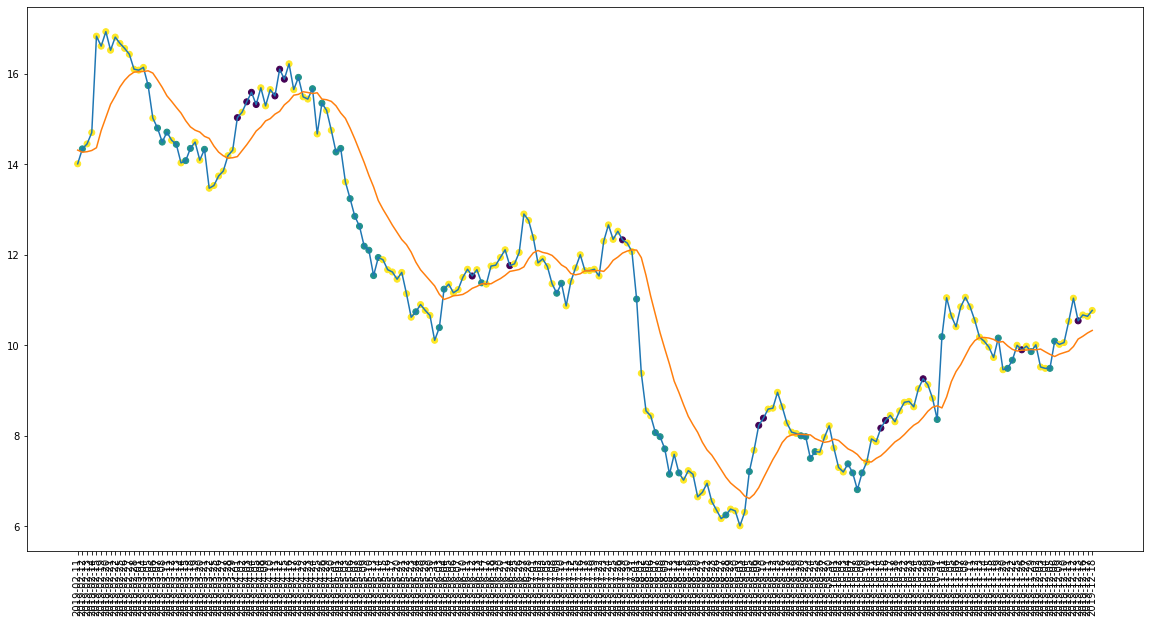

In [277]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

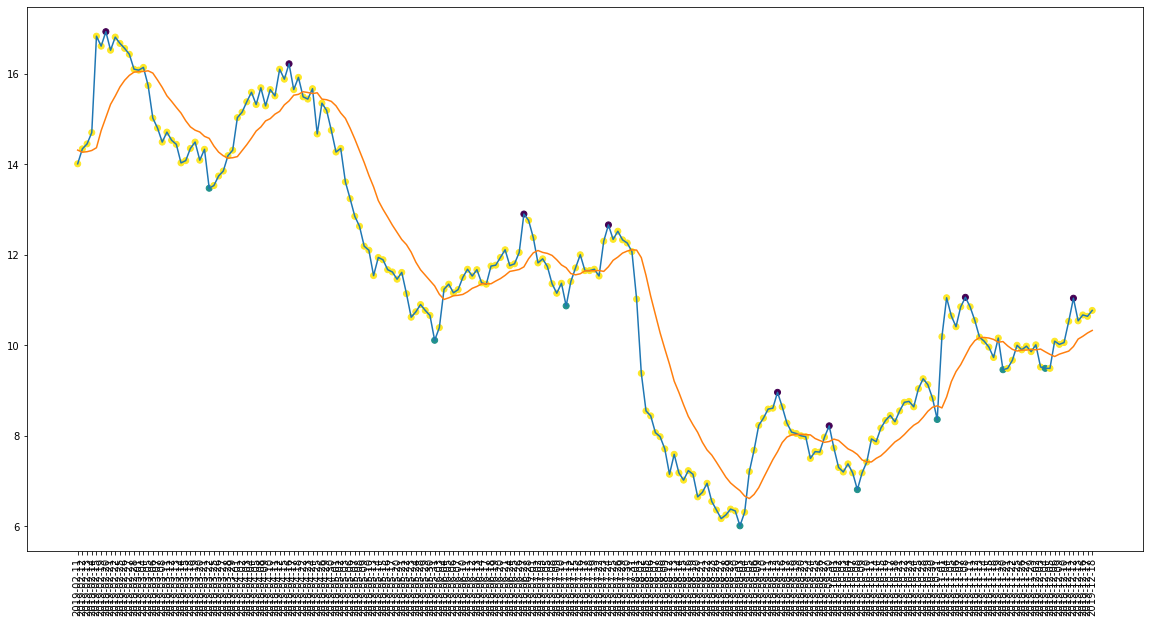

In [278]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [279]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 49
actual holds but predicted sell: 17
actual predicted holds: 136
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 67.32673267326733%
actual buys: 8
actual sells: 8
actual holds: 202


In [280]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 43.13725490196079%
Percentage sells correct: 52.94117647058823%
Percentage holds correct: 83.22147651006712%


In [281]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.34000015258789
Shares owned at the moment: 695
Cash capital at the moment: $6.2925686597827735


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9342.198216234443


Share price: $15.920000076293945
Shares owned at the moment: 585
Cash capital at the moment: $3.3868714797463326


Stop Loss Activated!

Share price: $15.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9010.947526679036


Share price: $15.670000076293945
Shares owned at the moment: 573
Cash capital at the moment: $7.34548034238469


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8390.139271438595


Share price: $15.350000381469727
Shares owned at the moment: 545
Cash capital at the moment: $1.3832504658657854


Stop Loss Activated!

Share price: $14.75
Shares owned at the moment: 0
Cash capital at the moment: $8018.026687965866


Share price: $14.27000

In [282]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [283]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.637615   44.44444444444444%   55.55555555555556%   
1       0.623256                62.5%  33.333333333333336%   
2       0.674312                37.5%   55.55555555555556%   
3       0.753488                25.0%                60.0%   
4       0.431280                37.5%   22.22222222222222%   
5       0.502347                80.0%                70.0%   
6       0.720183  27.272727272727273%  16.666666666666668%   
7       0.753425                 0.0%   8.333333333333334%   
8       0.633027                25.0%                 0.0%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   
5   47.66839378238342%  48.275862068965516%  58.62068965517241%   
6   76.11940298507463%                56.0%  40.74074074074074%   
7     83.248730964467%   47.05882352941177%  52.94117647058823%   
8   67.32673267326733%   43.13725490196079%  52.94117647058823%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%  
5  88.54166666666667%   -6.716807591142733%   -41.56249103630067%  
6  84.84848484848484%    22.39773028585425%    35.77290673755644%  
7  80.97826086956522%  -34.673518536567755%   -14.13141708526613%  
8  83.22147651006712%  -44.264759962737685%  -23.520909336075793%

### recession

In [284]:
logger = []

In [285]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [286]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(#j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [288]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [289]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [290]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1372 - accuracy: 0.7169 - mean_squared_error: 1.8958 - weighted_accuracy: 0.7169 - weighted_mean_squared_error: 1.8958
Test loss: 0.13724449276924133
Test accuracy: 0.7168949842453003


In [291]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 0: 22, 1: 30})

In [292]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [293]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [294]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            0   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            1   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

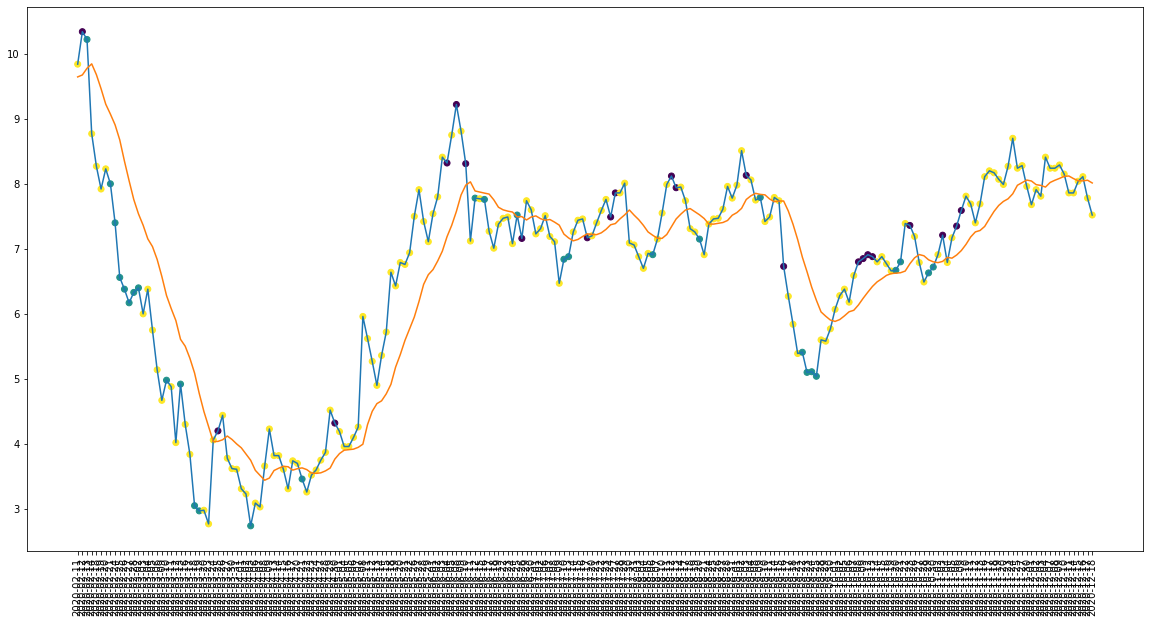

In [295]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

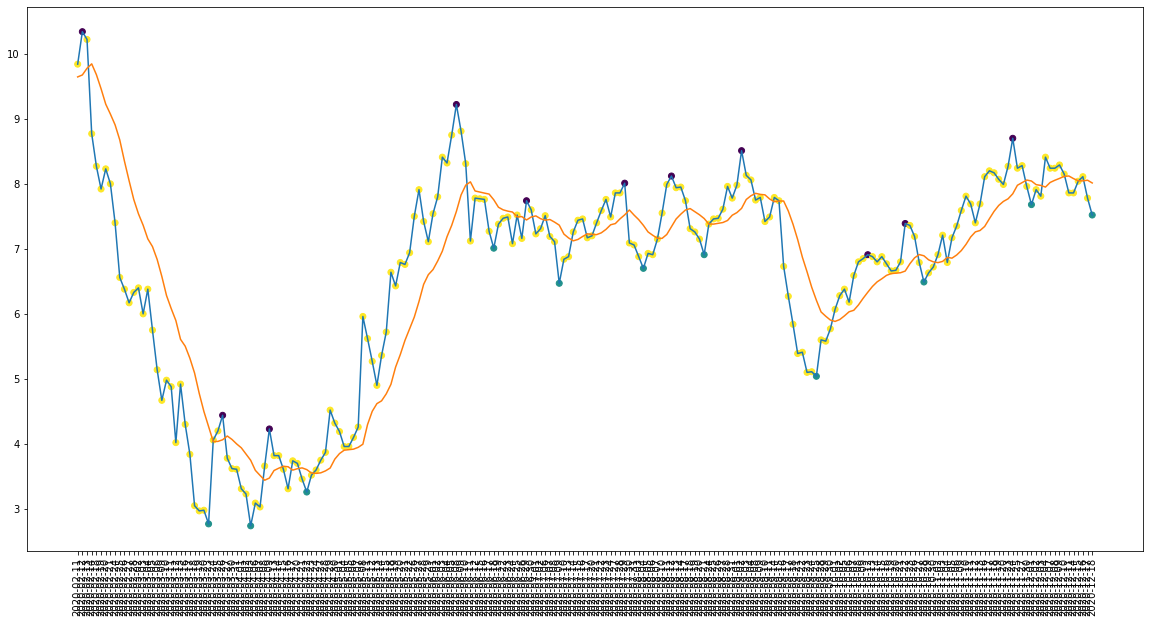

In [296]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [297]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 28
actual holds but predicted sell: 18
actual predicted holds: 151
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 76.6497461928934%
actual buys: 11
actual sells: 11
actual holds: 197


In [298]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 56.666666666666664%
Percentage sells correct: 68.18181818181819%
Percentage holds correct: 84.33734939759036%


In [299]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.220000267028807
Shares owned at the moment: 975
Cash capital at the moment: $8.097363930941356


Stop Loss Activated!

Share price: $8.770000457763674
Shares owned at the moment: 0
Cash capital at the moment: $8535.333246523143


Share price: $8.0
Shares owned at the moment: 1063
Cash capital at the moment: $7.947246523142894


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $7852.51529761994


Share price: $7.400000095367432
Shares owned at the moment: 1058
Cash capital at the moment: $1.7848964437253017


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $6923.178516070962


Share price: $6.559999942779541
Shares owned at the moment: 1052
Cash capital at the moment: $3.080496432423388


Stop Loss Activated!

Share price: $6.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $6696.383276493191


Share price: $6.3800001144

In [300]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [301]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.637615   44.44444444444444%   55.55555555555556%   
1       0.623256                62.5%  33.333333333333336%   
2       0.674312                37.5%   55.55555555555556%   
3       0.753488                25.0%                60.0%   
4       0.431280                37.5%   22.22222222222222%   
5       0.502347                80.0%                70.0%   
6       0.720183  27.272727272727273%  16.666666666666668%   
7       0.753425                 0.0%   8.333333333333334%   
8       0.633027                25.0%                 0.0%   
9       0.716895  18.181818181818183%   36.36363636363637%   

         correct_holds     correct_low_buys  correct_high_sells  \
0                65.0%  57.142857142857146%  43.18181818181818%   
1   63.63636363636363%   54.54545454545455%               72.0%   
2    69.1542288557214%   47.61904761904762%   65.3061224489796%   
3   79.27461139896373%               56.25%  66.66666666666667%   
4  44.329896907216494%   58.62068965517241%  54.54545454545455%   
5   47.66839378238342%  48.275862068965516%  58.62068965517241%   
6   76.11940298507463%                56.0%  40.74074074074074%   
7     83.248730964467%   47.05882352941177%  52.94117647058823%   
8   67.32673267326733%   43.13725490196079%  52.94117647058823%   
9    76.6497461928934%  56.666666666666664%  68.18181818181819%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   81.8840579710145%   -4.180562670910404%    -7.30802773938658%  
1  87.31343283582089%  -40.609763038500056%  -48.998182398364555%  
2  86.39455782312925%    4.783348022520549%   -5.545324129943856%  
3  87.87878787878788%    1.985793325576724%   -7.669883276367181%  
4  78.35051546391753%   -32.38738890206578%  -10.879329186439518%  
5  88.54166666666667%   -6.716807591142733%   -41.56249103630067%  
6  84.84848484848484%    22.39773028585425%    35.77290673755644%  
7  80.97826086956522%  -34.673518536567755%   -14.13141708526613%  
8  83.22147651006712%  -44.264759962737685%  -23.520909336075793%  
9  84.33734939759036%   -7.402309267512701%   -23.98520794264914%

In [302]:
experiment

'No willr CNN Images Experiments - cyclic'

In [303]:
log.to_csv('{}.csv'.format(experiment))